# D208 Predictive Modeling: Logistic Regression

In [2]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Part I: Research Question

## A1. Research Question

My research question is, what factors if any are the cause of readmissions occurring? What features are correlated to a patient being readmitted to a hospital within 30 days?





## A2.  Goals of the Data Analysis.
The goals of this data analysis are essentially to uncover what factors influence whether a patient is readmitted within 30 days of release. By examining the data, I aim to uncover key relationships between patients who are readmitted and those who are not. This analysis could help identify which demographics/characteristics are more prone to readmission, as well as identify geographical areas and hospital stay events that may impact readmission. The insights gathered here could provide valuable understanding for improving patient care and reducing readmission rates.

# Part II: Method Justification

## B1.  Four Assumptions of a Logistic Regression Model.
- The target variable should be binary or ordinal, in this case binary.
- Each observation (row) should be independent of each other, avoiding any repeat entries or matched data.
- No Multicollinearity, meaning the features in the dataset should be independent of one another or have very little multicollinearity. Otherwise, the relationship between the dependent and independent variables will be difficult to identify.
-No extreme outliers. Logistic regression works by modeling a relationship through probabilities scaled between 0 and 1. Anamalous values negatively affect the variable coefficients causing the model to train poorly.

## B2.  Benefits of using Python
Python is my choice of programming language due to it's ease of use and robust use in data science. Python has many versatile libraries including numpy (numerical python operations), pandas (used for manipulation of dataframes), scipy (used for statistical operations), and matplotlib and seaborn (strong versatile visualization packages).

During the wrangling phase, Python's pandas library proves to be incredibly useful for the manipulation of dataframes, including cleaning, transforming and creating new features. It also have many useful functions needed to help prepare dataframes for modeling such as functions to fill nulls or to change data types. Numpy is also an analyst favorite with it's powerful performance with numerical operations on arrays.

Data exploration and statistics phases also greatly benefit from the various functions within Python. The visual libraries including matplotlib and seaborn have versatile graphs that provide easy access to quick insights. Distribution charts, scatterplots and heatmaps are a few of my most used functions that help assess the distribution and relative relation to features within the dataset.

In summary, python's versatile libraries, ease of use and large community make it a strong tool for data science.

## B3.  Explain why logistic regression is an appropriate technique to analyze the research question summarized in part I.
- Logistic regression is quite similar to linear regression, but instead uses probability to predict which class each observation belongs to. In a dataset with a binary target variable, the algorithm essentially "takes input as independent variables and produces a probability value between 0 and 1" (*Geeks for Geeks, Understanding Logistic Regression*). The default threshold is set to 0.5 and if an input is >=5 then the input is considered positive, or 1.
- In contrast to linear, logistic regression employs a logit function (Sigmoid) shaped like an **S** on a graph where the y-Dina here because yeah I'm sick oh OK bye yes day go to school King I forgot doorvalue range is (0,1). 
- This technique is more than appropriate for our current business problem as we are aiming to predict whether a patient was readmitted (1) or not (0). 

# Part III: Data Preparation

## C1.  Describe your data cleaning goals and the steps used to clean the data to achieve the goals that align with your research question including the annotated code.

In line with my previous data cleaning approach from D206 and linear regression, my plan is to systematically assess and clean the dataframe as needed. I will evaluate the data types of each column and convert them to appropriate types such as integer, float, or boolean. Next, I will identify and address any duplicates or missing values by either removing, separating, or imputing them. For this dataset, duplicates and null values are not present. Finally, I will conduct a thorough review of the data to ensure its accuracy, which may involve correcting spelling errors, fixing typos, and standardizing text formatting for readability.

To clean the dataset, I will begin by ensuring all zip codes are at least five digits by padding with zeros where necessary. The timezone column will be standardized to align with the nine main time zones and converted to a categorical data type. Columns such as readmission, soft_drink, and other health related variables with yes/no or (1,0) responses will be converted to boolean data types. Values in columns like vitd_levels, daily_charges, and additional_charges will be rounded to two decimal places. Columns such as population, children, and income will be corrected from float to integer types.

Columns including marital, gender, and other service related fields will be designated as categorical data types. As columns like income fall within reasonable bounds, no further change will be applied.

In [3]:
# bring in dataframe
df = pd.read_csv('medical_raw_df.csv', index_col=[0])
# lowercase columns
df.columns = map(str.lower, df.columns)

# verify no nulls
assert df.isnull().sum().sum() == 0
# verify no duplicates
assert df.duplicated().sum() == 0

    
# change timezone column entries before changing data type
tz_dict = {
    "America/Puerto_Rico" : "US - Puerto Rico",
    "America/New_York": "US - Eastern",
    "America/Detroit" : "US - Eastern",
    "America/Indiana/Indianapolis" : "US - Eastern",
    "America/Indiana/Vevay" : "US - Eastern",
    "America/Indiana/Vincennes" : "US - Eastern",
    "America/Kentucky/Louisville" : "US - Eastern",
    "America/Toronto" : "US - Eastern",
    "America/Indiana/Marengo" : "US - Eastern",
    "America/Indiana/Winamac" : "US - Eastern",
    "America/Chicago" : "US - Central", 
    "America/Menominee" : "US - Central",
    "America/Indiana/Knox" : "US - Central",
    "America/Indiana/Tell_City" : "US - Central",
    "America/North_Dakota/Beulah" : "US - Central",
    "America/North_Dakota/New_Salem" : "US - Central",
    "America/Denver" : "US - Mountain",
    "America/Boise" : "US - Mountain",
    "America/Phoenix" : "US - Arizona",
    "America/Los_Angeles" : "US - Pacific",
    "America/Nome" : "US - Alaskan",
    "America/Anchorage" : "US - Alaskan",
    "America/Sitka" : "US - Alaskan",
    "America/Yakutat" : "US - Alaskan",
    "America/Adak" : "US - Aleutian",
    "Pacific/Honolulu" : 'US - Hawaiian'
    }
df.timezone.replace(tz_dict, inplace=True)

# convert zip column to str, then fill 0s in entries
df.zip = df.zip.astype('str').str.zfill(5)

# changing datatypes
# change columns to boolean data type
to_bool = ['readmis',
           'soft_drink',
           'highblood',
           'stroke',
           'overweight',
           'arthritis',
           'diabetes',
           'hyperlipidemia',
           'backpain',
           'anxiety',
           'allergic_rhinitis',
           'reflux_esophagitis',
           'asthma']

for col in to_bool:
    df[col] = df[col].replace({'Yes':1, 'No':0}).astype(bool)


# round entries in columns to only have two decimal places
round_num = ['vitd_levels',
             'totalcharge',
             'additional_charges']
for col in round_num:
    df[col] = round(df[col], 2)

# change columns to integer data type
to_int = ['population',
          'children',
          'age',
          'income',
          'initial_days']
for col in to_int:
    df[col] = df[col].astype('int32')

# change columns to categorical data type
to_cat = ['marital',
          'gender',
          'initial_admin',
          'services',
          'item1',
          'item2',
          'item3',
          'item4',
          'item5', 
          'item6',
          'item7',
          'item8',
          'timezone',
          'state',
          'complication_risk']
for col in to_cat:
    df[col] = df[col].astype('category')
      
# make columns more readable  
columns = {'caseorder':'case_order',
          'uid':'unique_id',
          'readmis':'readmission',
          'vitd_supp':'vitd_supplement',
          'highblood':'high_blood',
          'services':'services_received',
          'totalcharge':'daily_charges',
          'initial_days':'hospital_stay_days'}


df[['item1','item2', 'item3', 'item4']] = df[['item1','item2', 'item3', 'item4']].astype('int32')
df[['item5','item6', 'item7', 'item8']] = df[['item5','item6', 'item7', 'item8']].astype('int32')


df.rename(columns=columns, inplace=True)
df = df.reset_index()

In [14]:
# separate exploratory variables into type for ease of exploring

# ordinal variables
ordinal_vars = ['age',
             'income',
             'vitd_levels',
             'daily_charges',
             'additional_charges',
             'population',
             'children',
             'doc_visits',
             'full_meals_eaten',
             'vitd_levels',
             'vitd_supplement',
             'hospital_stay_days']

# categorical variables
cat_vars = ['gender', 
            'marital',
            'area',
            'timezone', 
            'initial_admin',
            'complication_risk',
            'services_received',
             'item1',
             'item2',
             'item3',
             'item4',
             'item5',
             'item6',
             'item7',
             'item8']


# List of boolean health-related variables
boolean_vars = ['high_blood', 
                'stroke',  
                'overweight', 
                'arthritis', 
                'diabetes', 
                'hyperlipidemia', 
                'backpain', 
                'anxiety', 
                'allergic_rhinitis', 
                'reflux_esophagitis', 
                'asthma',
                'full_meals_eaten',
                'soft_drink']

## C2.  Describe the dependent variable and all independent variables using summary statistics that are required to answer the research question, including a screenshot of the summary statistics output for each of these variables.

***Target Variable: Readmissions***

In [10]:
df.readmission.value_counts(normalize=True)

False    0.6331
True     0.3669
Name: readmission, dtype: float64

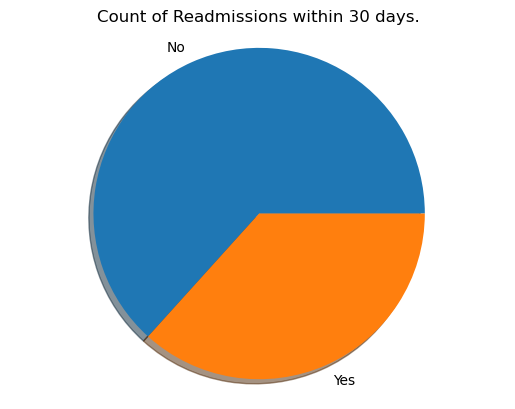

In [12]:
plt.pie(df.readmission.value_counts(normalize=True),
        labels = ['No', 'Yes'], shadow=True)
plt.axis('equal')
plt.title('Count of Readmissions within 30 days.')
plt.show()

### Numerical Variables

In [15]:
# statistics for numerical variables
numerical_summ = df[ordinal_vars].describe()
print('Summary statistics for numerical feature columns:\n')
numerical_summ.T

Summary statistics for numerical feature columns:



,count,mean,std,min,25%,50%,75%,max
age,10000.0,53.511700,20.638538,18.00,36.0000,53.00,71.00,89.00
income,10000.0,40490.002100,28521.152883,154.00,19598.2500,33768.00,54295.75,207249.00
vitd_levels,10000.0,17.964272,2.017259,9.81,16.6275,17.95,19.35,26.39
daily_charges,10000.0,5312.172758,2180.393815,1938.31,3179.3750,5213.95,7459.70,9180.73
additional_charges,10000.0,12934.528592,6542.601554,3125.70,7986.4850,11573.98,15626.49,30566.07
population,10000.0,9965.253800,14824.758614,0.00,694.7500,2769.00,13945.00,122814.00
children,10000.0,2.097200,2.163659,0.00,0.0000,1.00,3.00,10.00
doc_visits,10000.0,5.012200,1.045734,1.00,4.0000,5.00,6.00,9.00
full_meals_eaten,10000.0,1.001400,1.008117,0.00,0.0000,1.00,2.00,7.00
vitd_levels,10000.0,17.964272,2.017259,9.81,16.6275,17.95,19.35,26.39


### Categorical Variables

In [16]:
# distribution of categorical variables
print("\nDistribution for categorical variables:")
for var in cat_vars:
    print(f'\n{var}:')
    print(df[var].value_counts(normalize=True) * 100)  # display percentages


Distribution for categorical variables:

gender:
Female       50.18
Male         47.68
Nonbinary     2.14
Name: gender, dtype: float64

marital:
Widowed          20.45
Married          20.23
Separated        19.87
Never Married    19.84
Divorced         19.61
Name: marital, dtype: float64

area:
Rural       33.69
Suburban    33.28
Urban       33.03
Name: area, dtype: float64

timezone:
US - Eastern        43.26
US - Central        37.92
US - Pacific         9.37
US - Mountain        6.98
US - Arizona         1.00
US - Alaskan         0.69
US - Puerto Rico     0.43
US - Hawaiian        0.34
US - Aleutian        0.01
Name: timezone, dtype: float64

initial_admin:
Emergency Admission      50.60
Elective Admission       25.04
Observation Admission    24.36
Name: initial_admin, dtype: float64

complication_risk:
Medium    45.17
High      33.58
Low       21.25
Name: complication_risk, dtype: float64

services_received:
Blood Work     52.65
Intravenous    31.30
CT Scan        12.25
MRI      

### Bolean Variables

In [17]:
# Frequency distribution for boolean variables
print('Frequency distribution for boolean variables:')
for col in boolean_vars:
    print(f'\n{col}:')
    print(df[col].value_counts(normalize=True) * 100)  # display percentages

Frequency distribution for boolean variables:

high_blood:
False    59.1
True     40.9
Name: high_blood, dtype: float64

stroke:
False    80.07
True     19.93
Name: stroke, dtype: float64

overweight:
True     70.94
False    29.06
Name: overweight, dtype: float64

arthritis:
False    64.26
True     35.74
Name: arthritis, dtype: float64

diabetes:
False    72.62
True     27.38
Name: diabetes, dtype: float64

hyperlipidemia:
False    66.28
True     33.72
Name: hyperlipidemia, dtype: float64

backpain:
False    58.86
True     41.14
Name: backpain, dtype: float64

anxiety:
False    67.85
True     32.15
Name: anxiety, dtype: float64

allergic_rhinitis:
False    60.59
True     39.41
Name: allergic_rhinitis, dtype: float64

reflux_esophagitis:
False    58.65
True     41.35
Name: reflux_esophagitis, dtype: float64

asthma:
False    71.07
True     28.93
Name: asthma, dtype: float64

full_meals_eaten:
0    37.15
1    36.15
2    18.56
3     6.12
4     1.69
5     0.25
6     0.06
7     0.02
Name: f

## C3.  Univariate and Bivariate Visualizations 
- distributions of the dependent and independent variables, including the dependent variable in your bivariate visualizations.

#### Univariate Visualizations
***Target Variable***

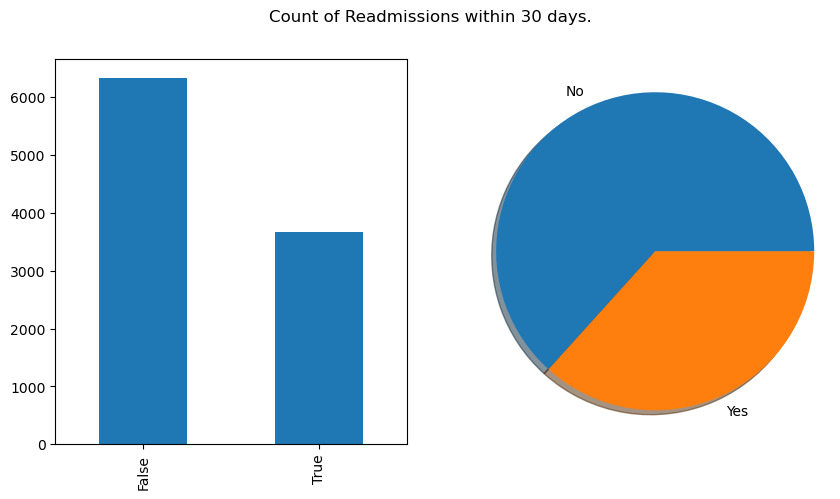

In [20]:
## Readmission
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
df.readmission.value_counts().plot(kind='bar')

plt.subplot(1, 2, 2)
plt.pie(df.readmission.value_counts(normalize=True),
        labels = ['No', 'Yes'], shadow=True)
plt.axis('equal')
plt.suptitle('Count of Readmissions within 30 days.')
plt.show()

***Numerical Variables***

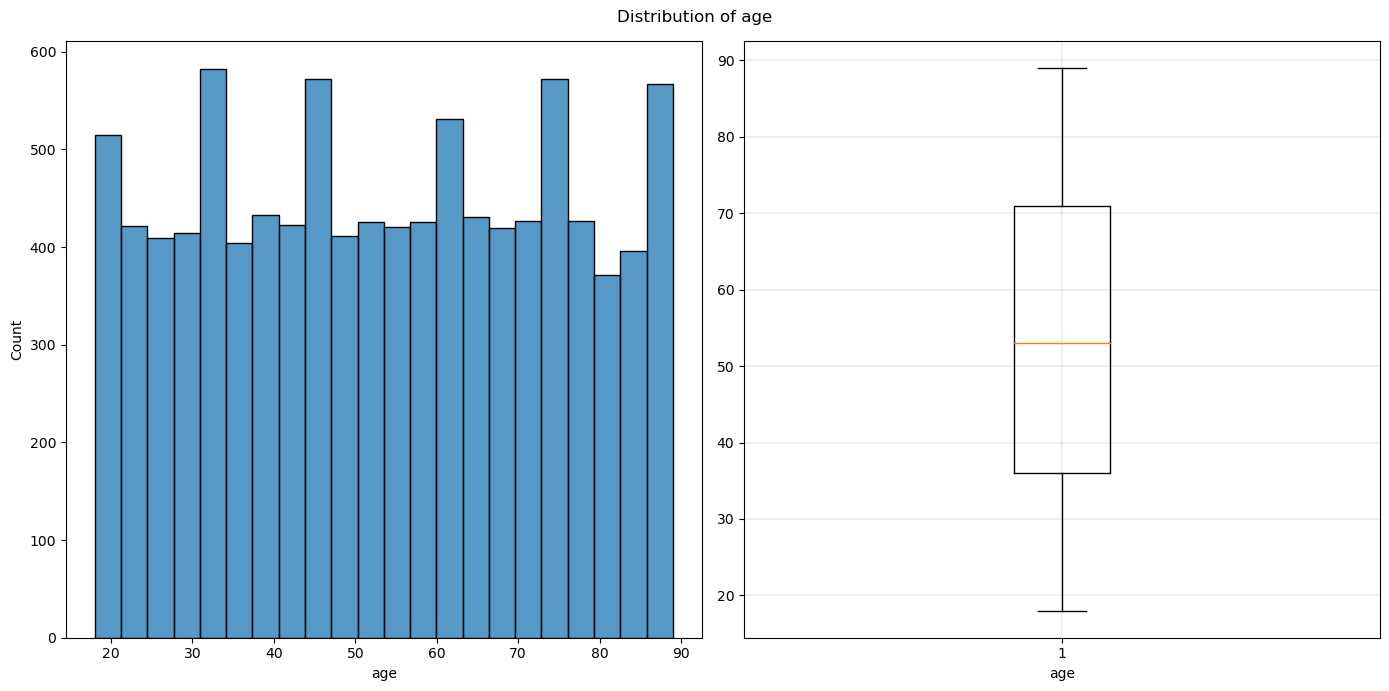

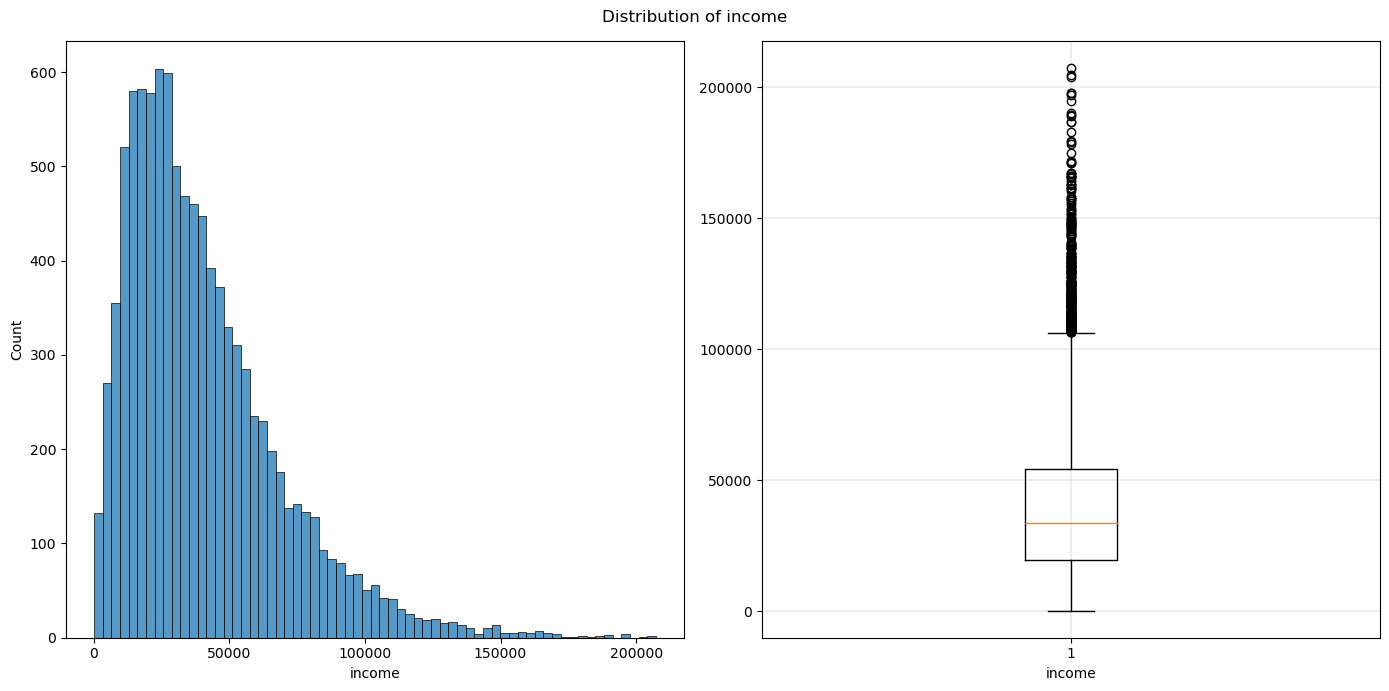

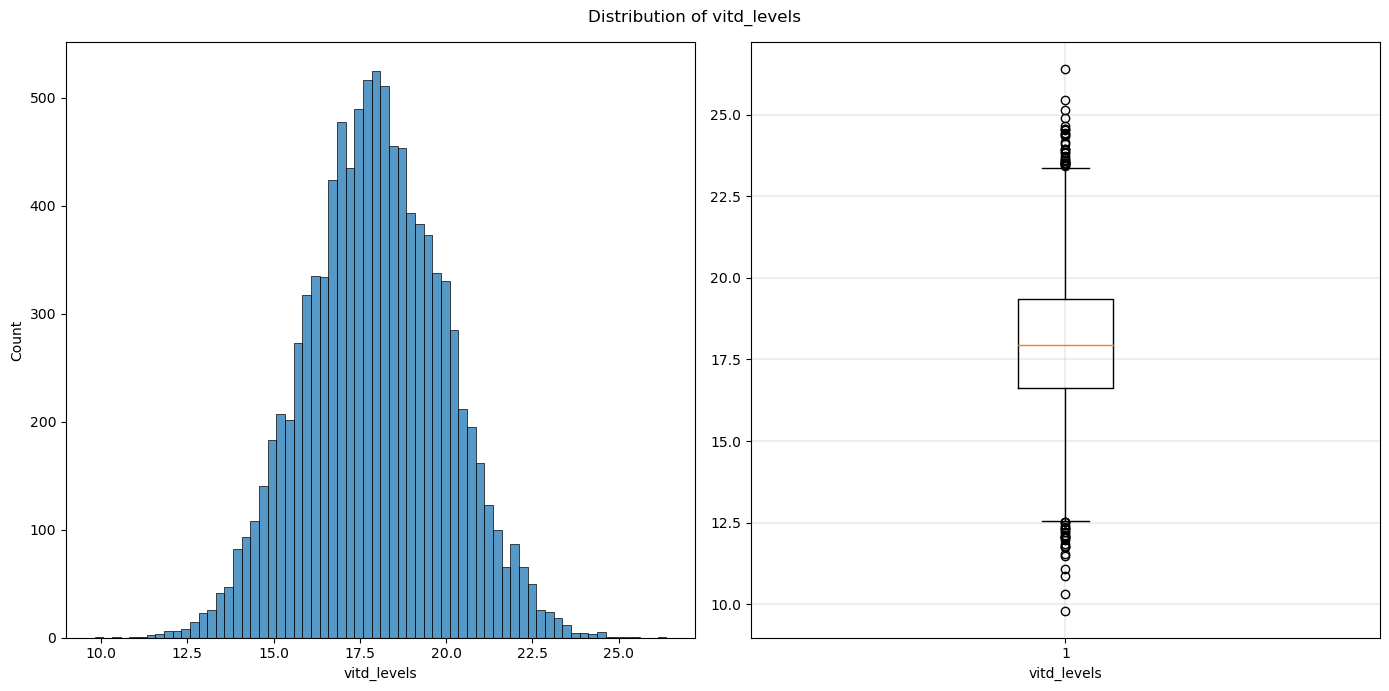

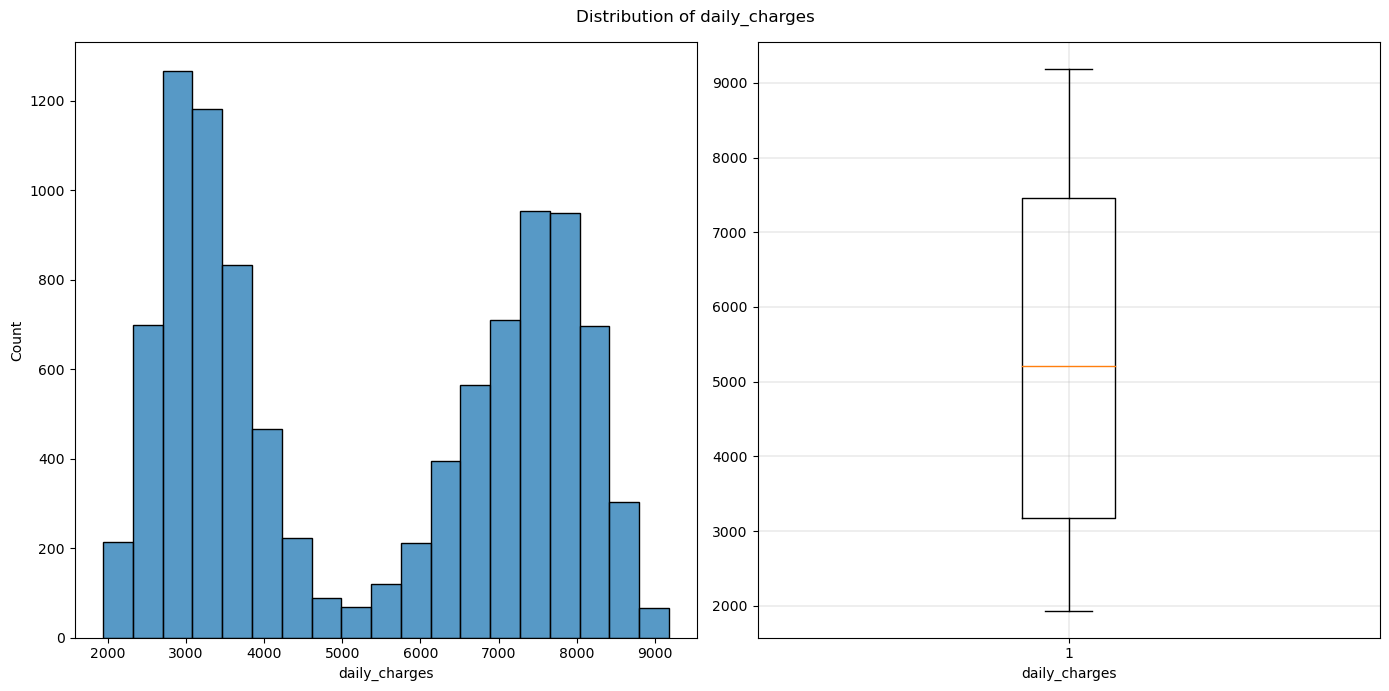

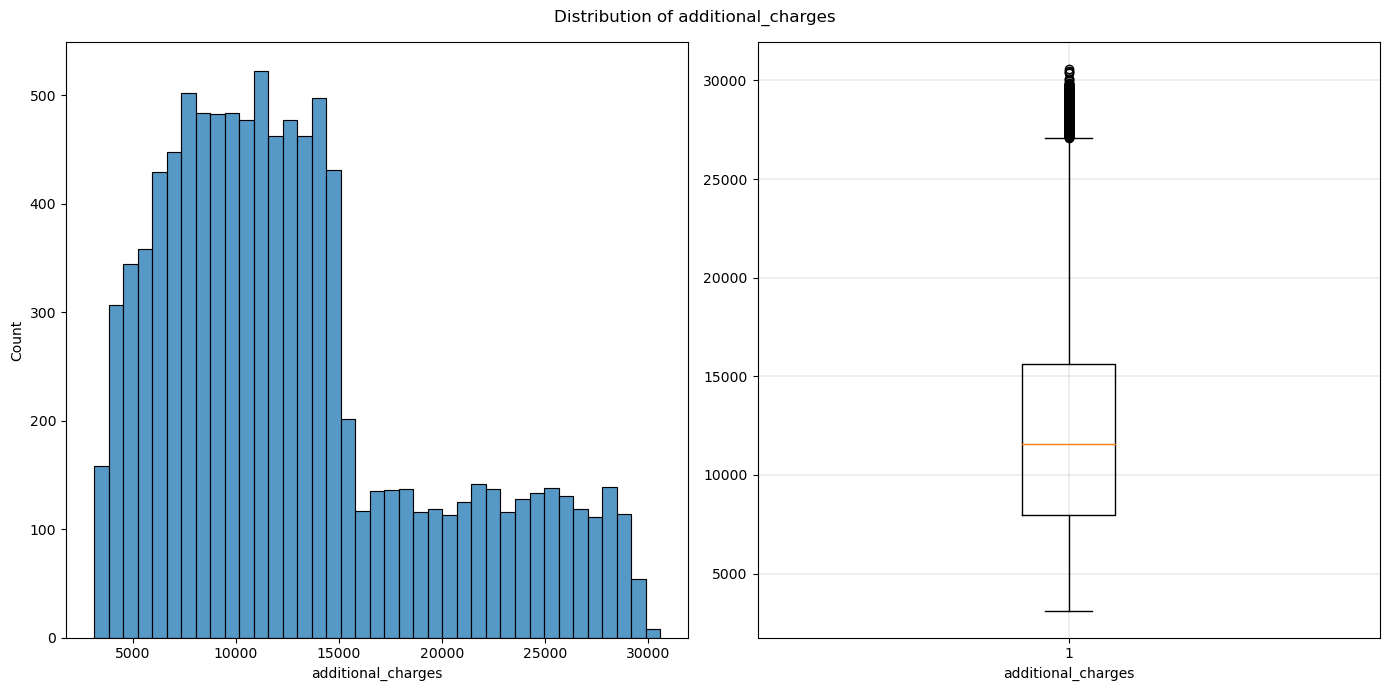

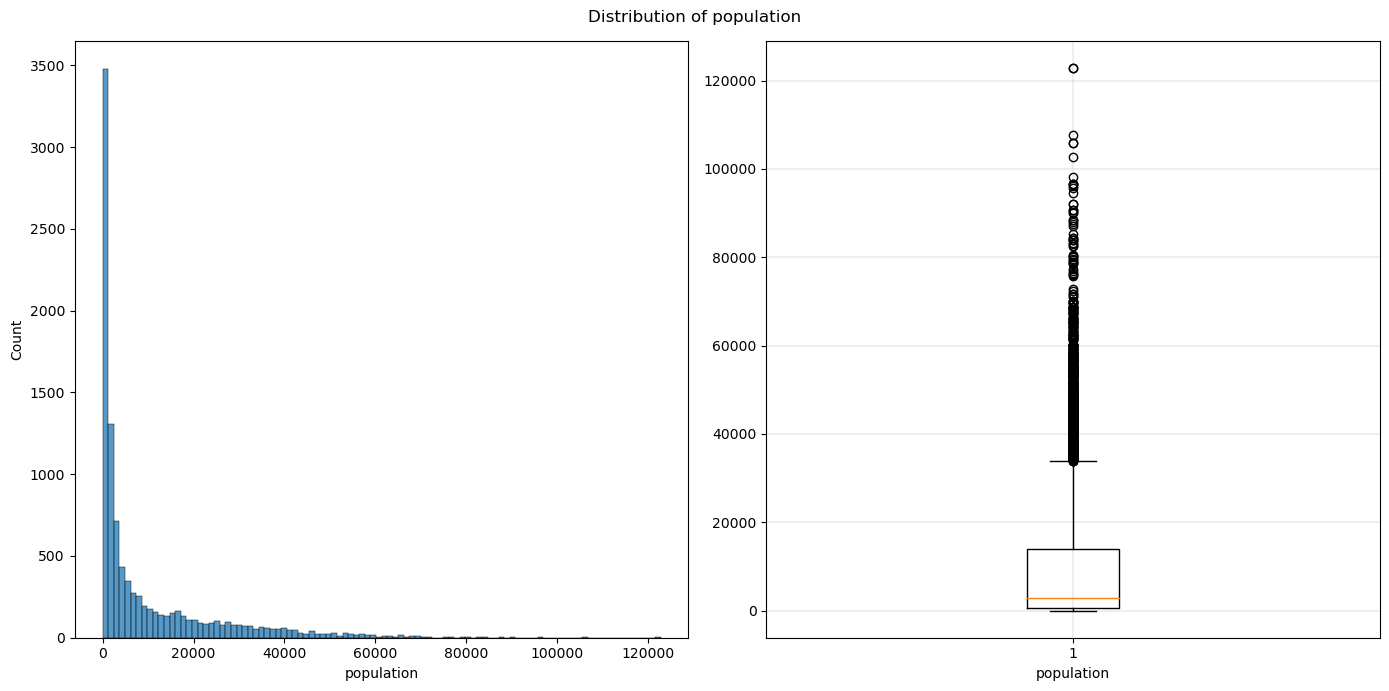

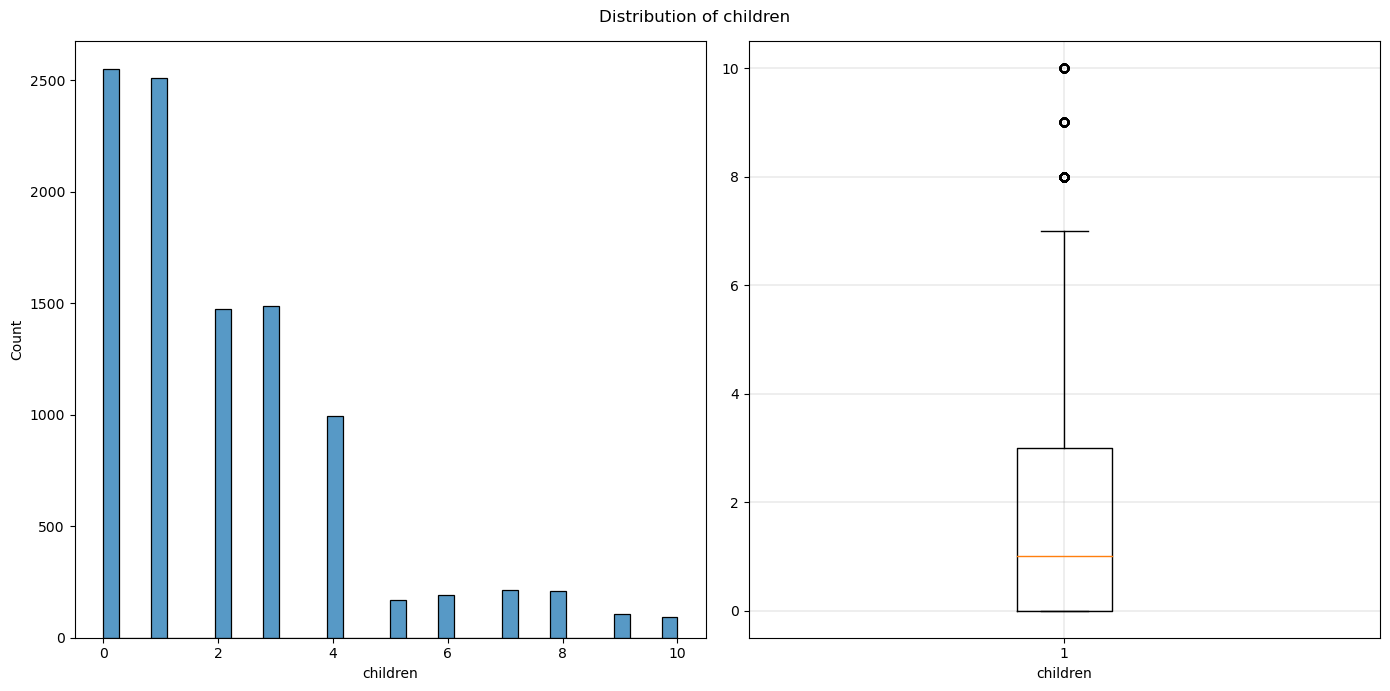

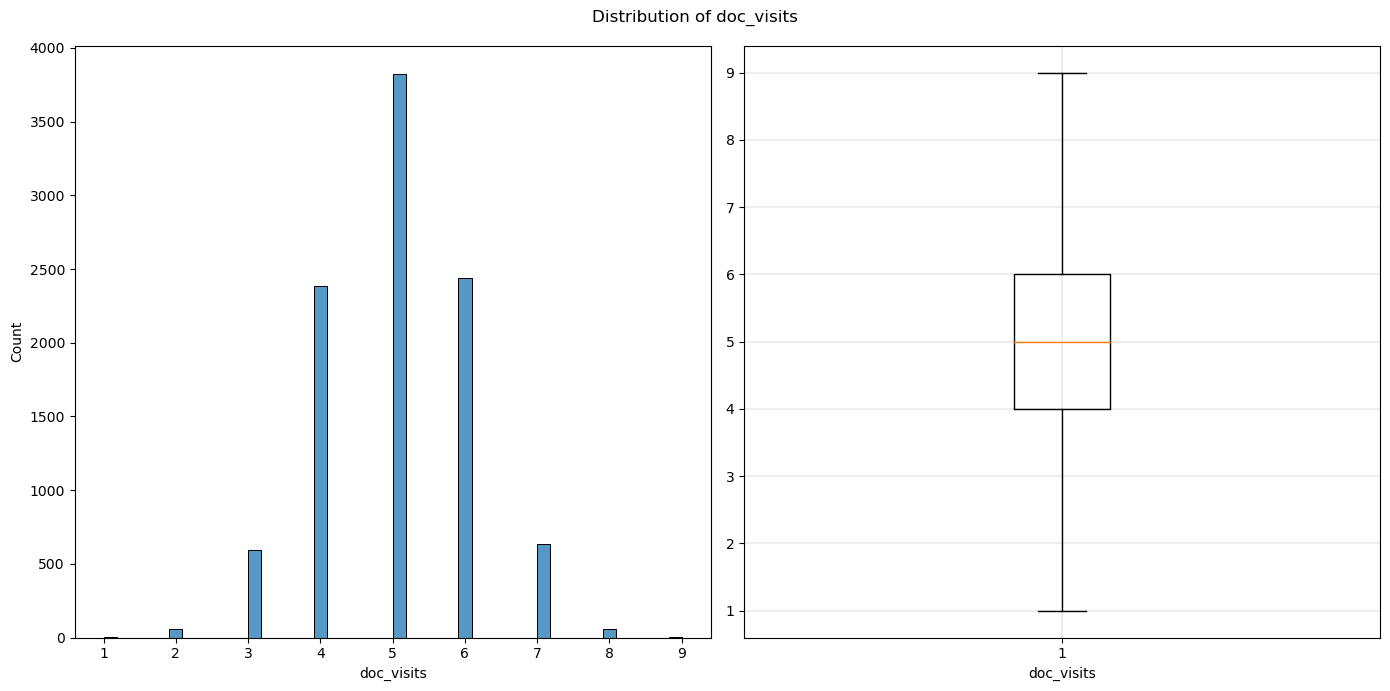

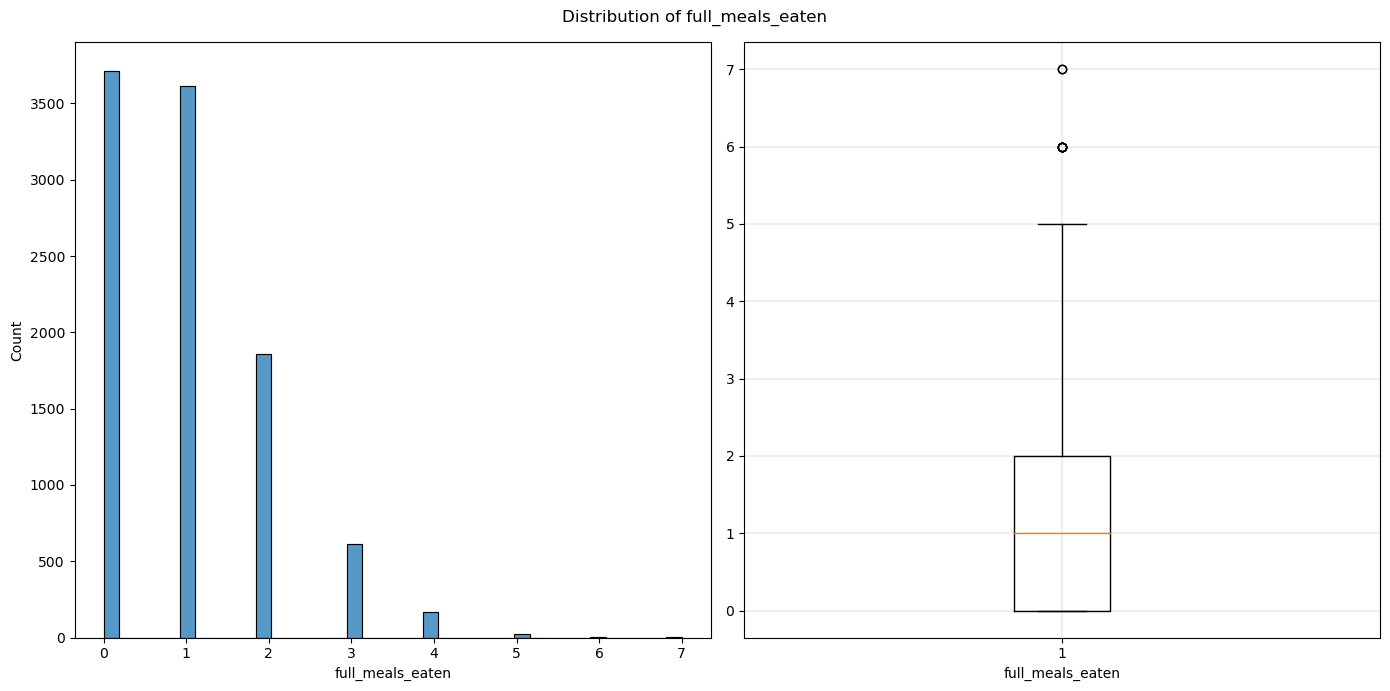

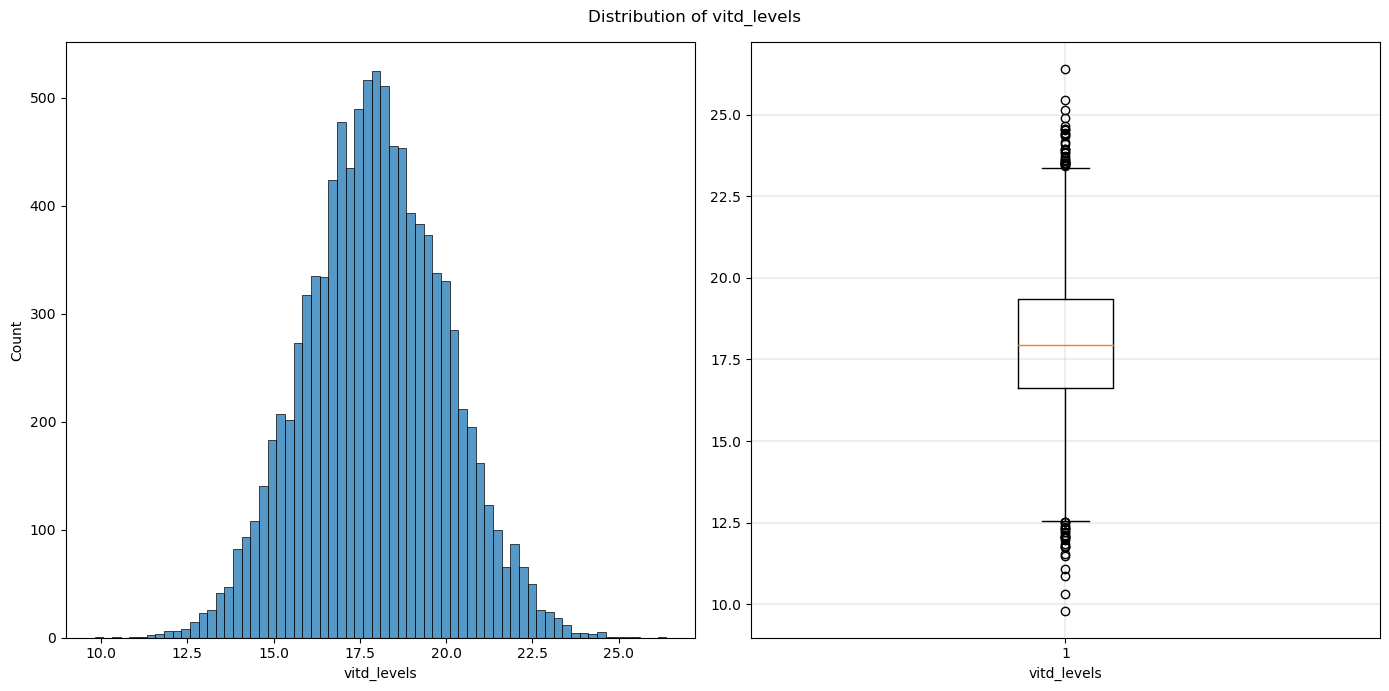

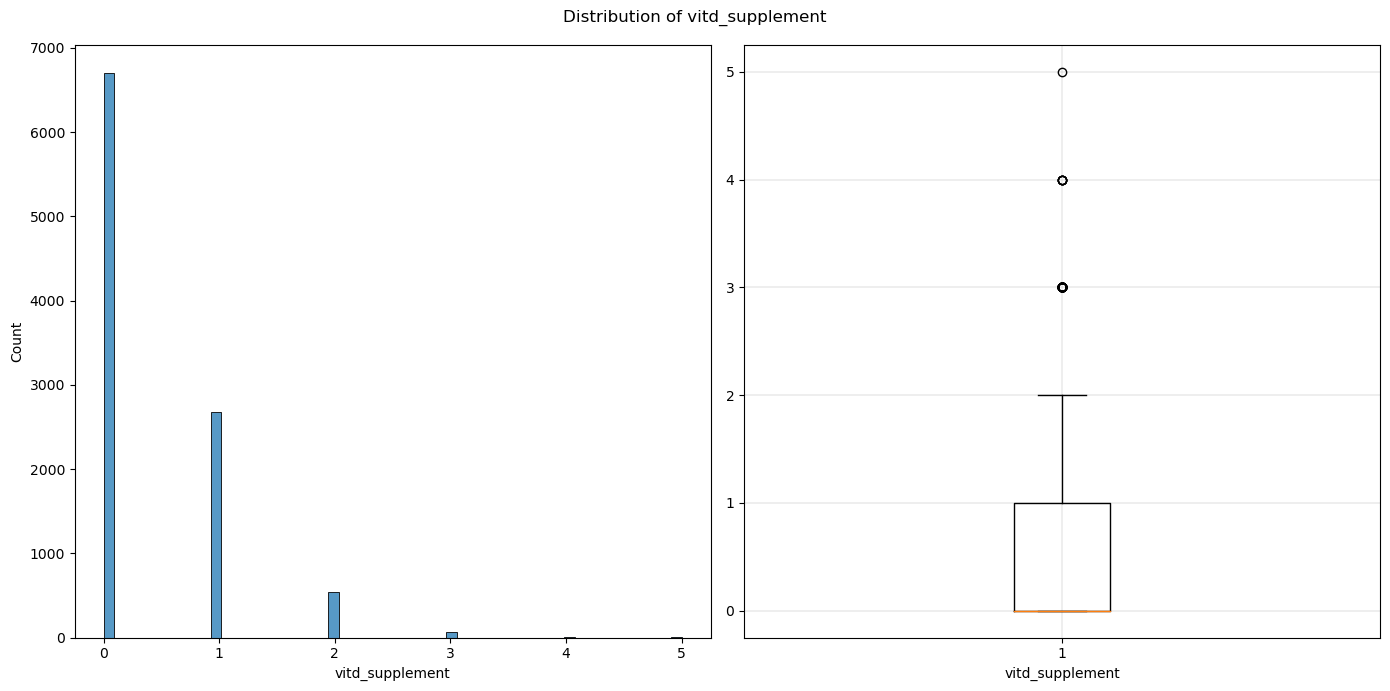

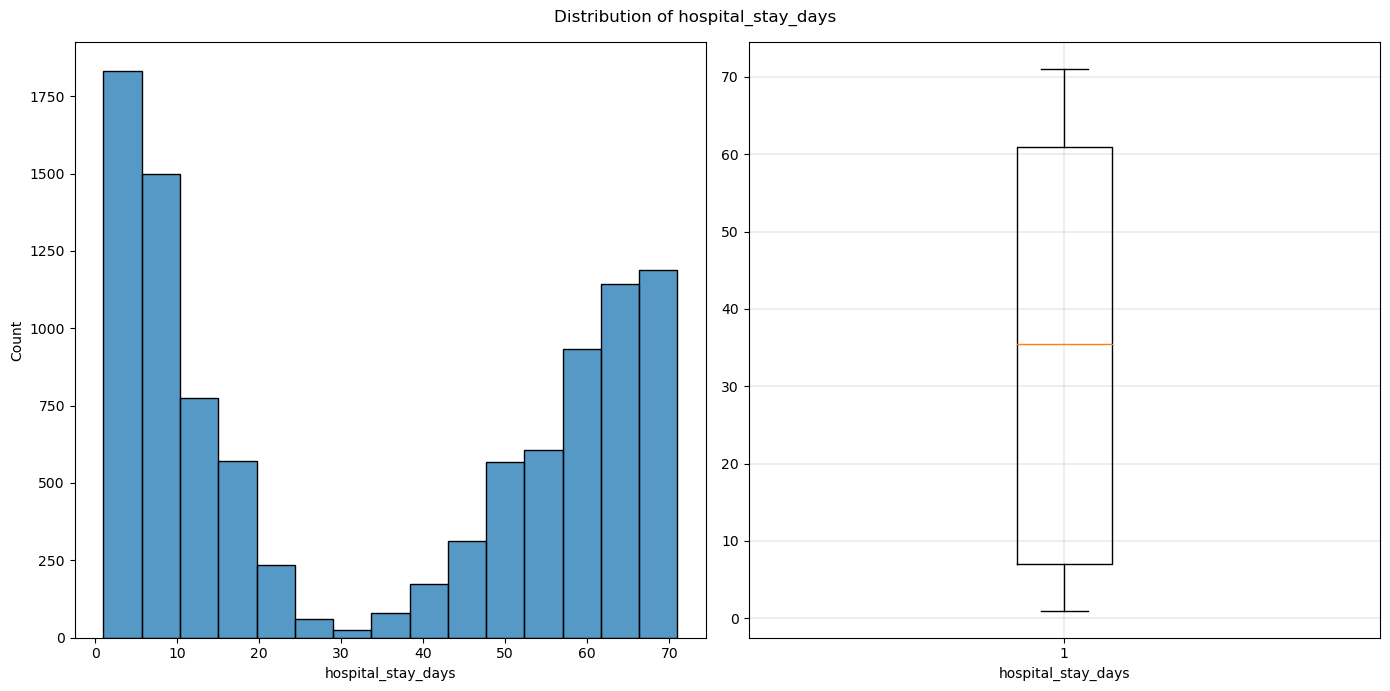

In [25]:
# distribution plot along with boxplot
for col in ordinal_vars:
    plt.figure(figsize=(14, 7))
    
    # hist
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=col)
    
    plt.xlabel(col)
    
    # boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(df[col])
    plt.xlabel(col)
     
    plt.grid(linewidth=0.3)    
    plt.suptitle(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

***Categorical Variables***

Distribution for categorical variables:


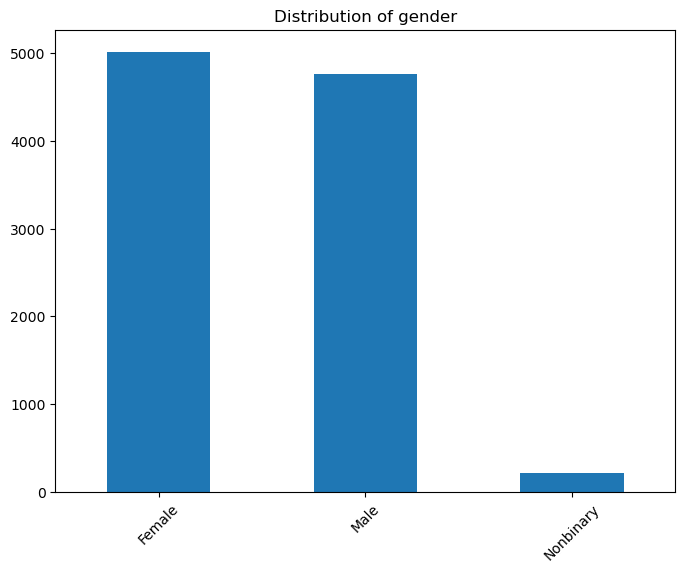

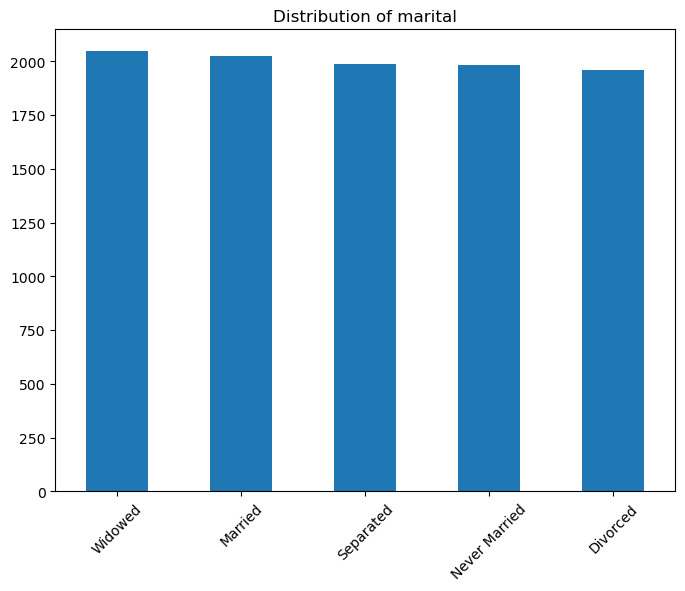

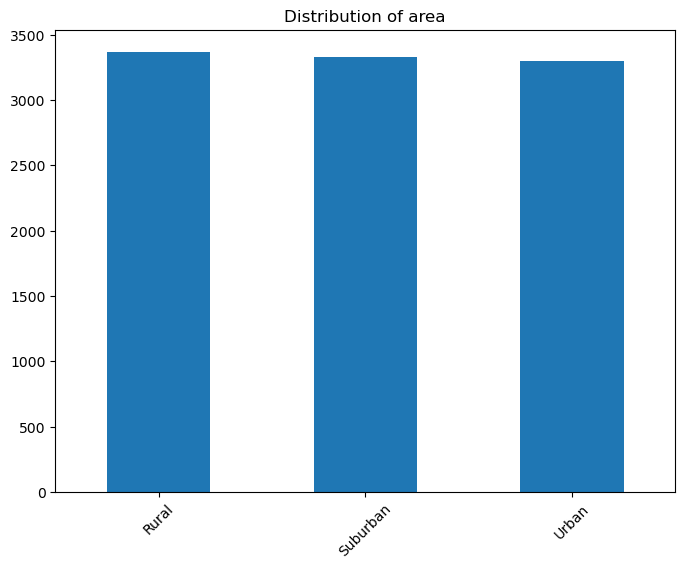

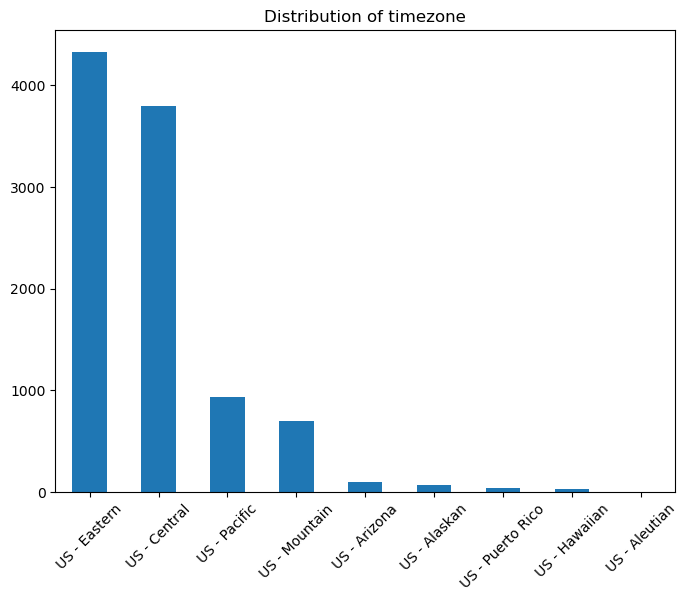

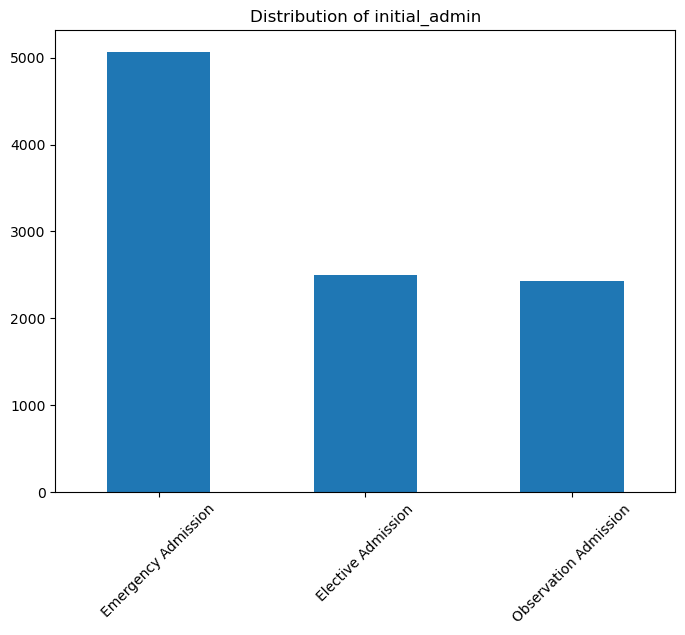

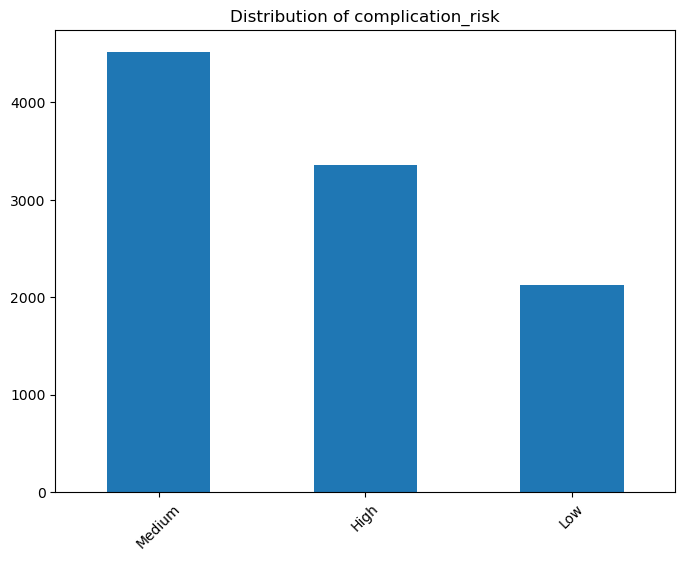

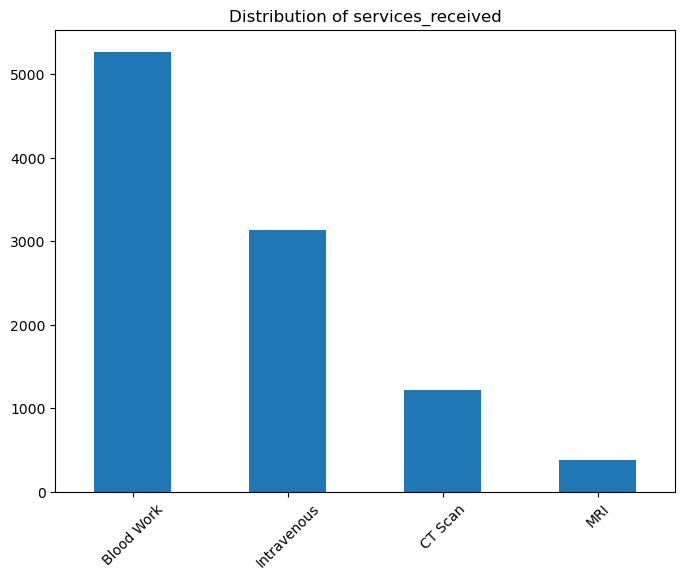

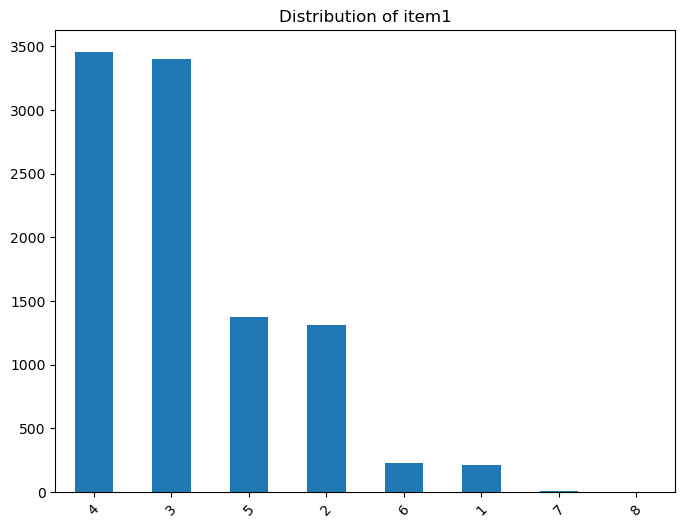

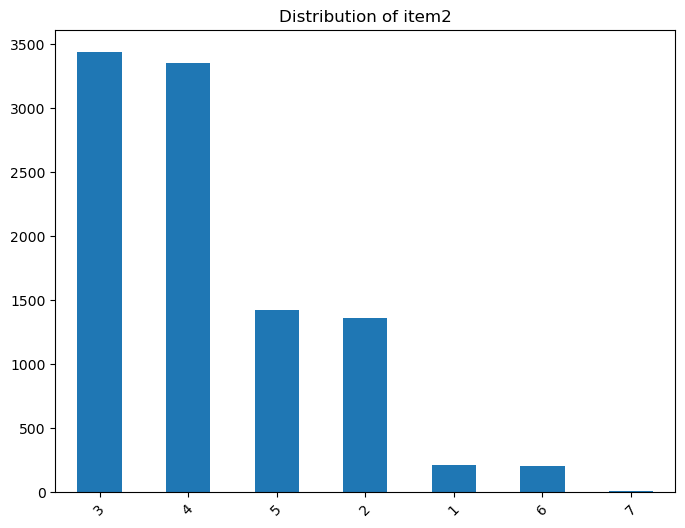

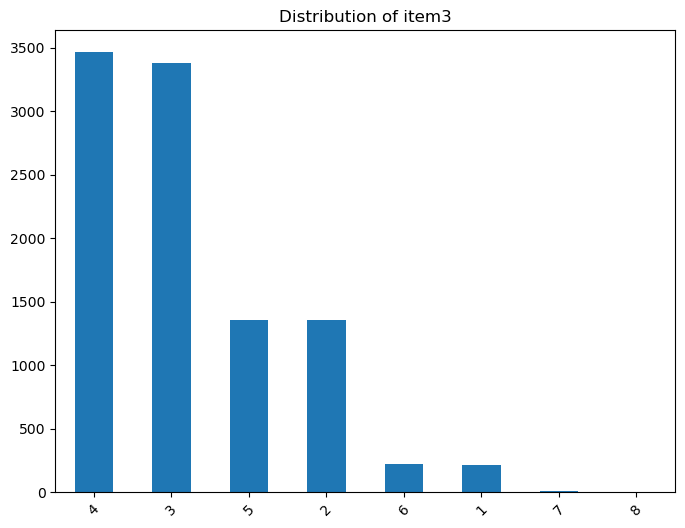

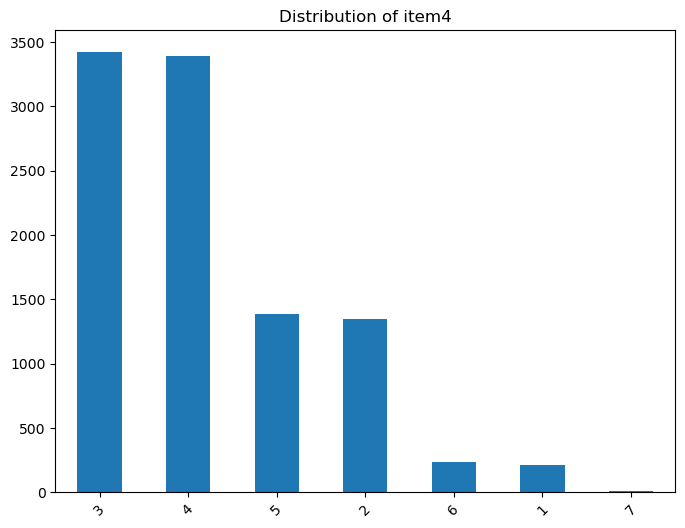

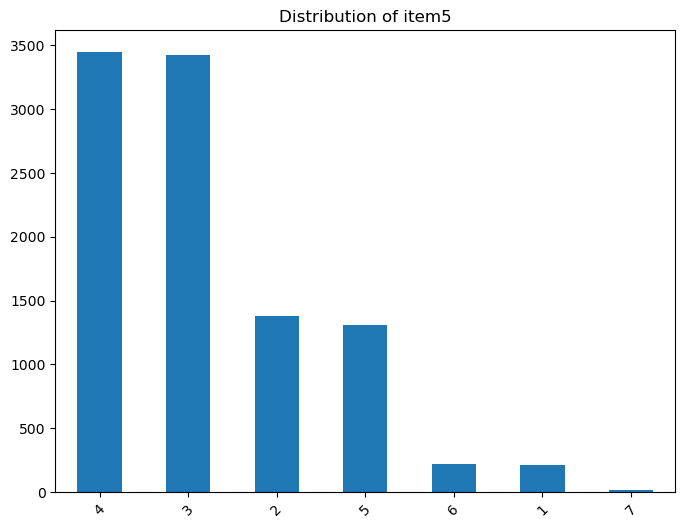

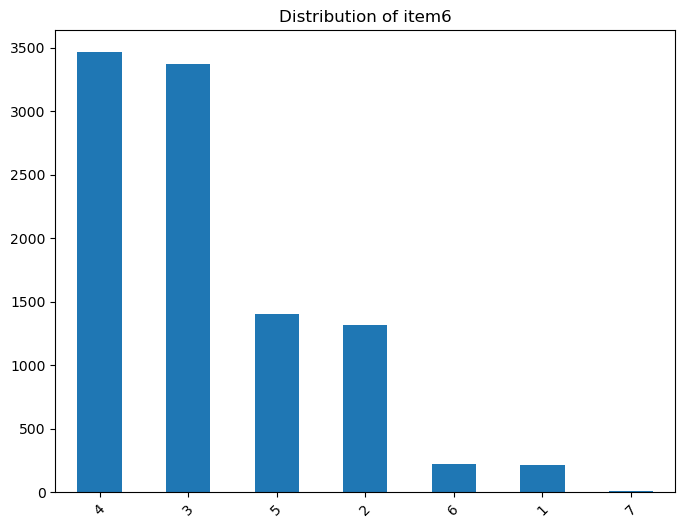

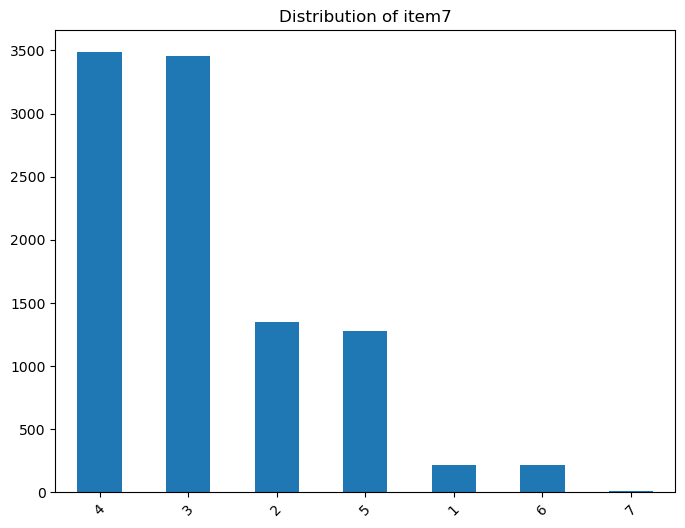

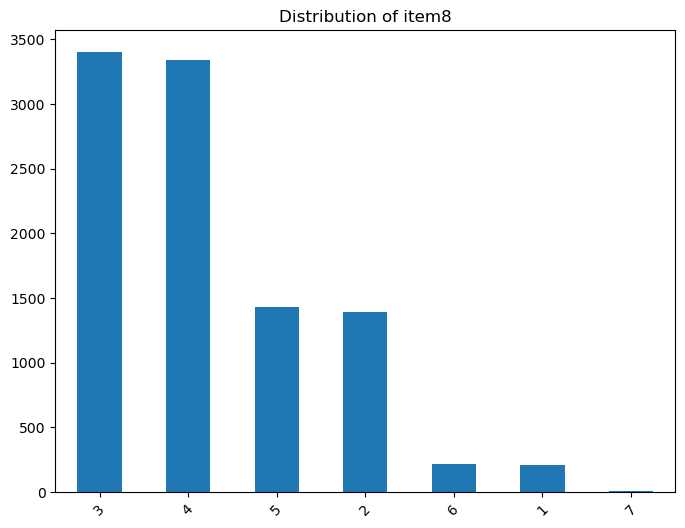

In [28]:
# distribution of categorical variables
print('Distribution for categorical variables:')
for var in cat_vars:
    plt.figure(figsize=(8,6))
    df[var].value_counts().plot(kind='bar') 
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {var}')
    plt.show()

***Boolean Variables***

Frequency distribution for boolean variables:


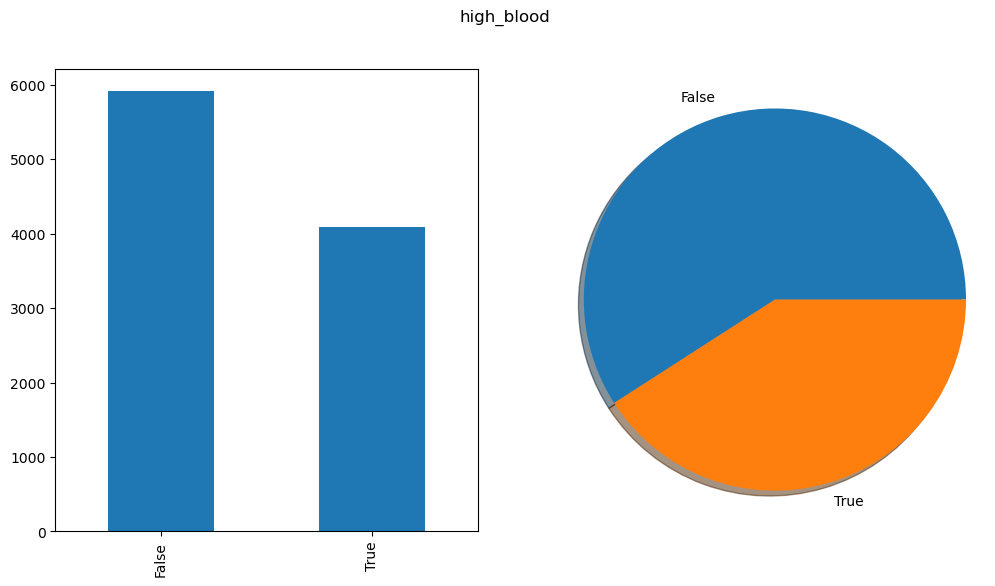

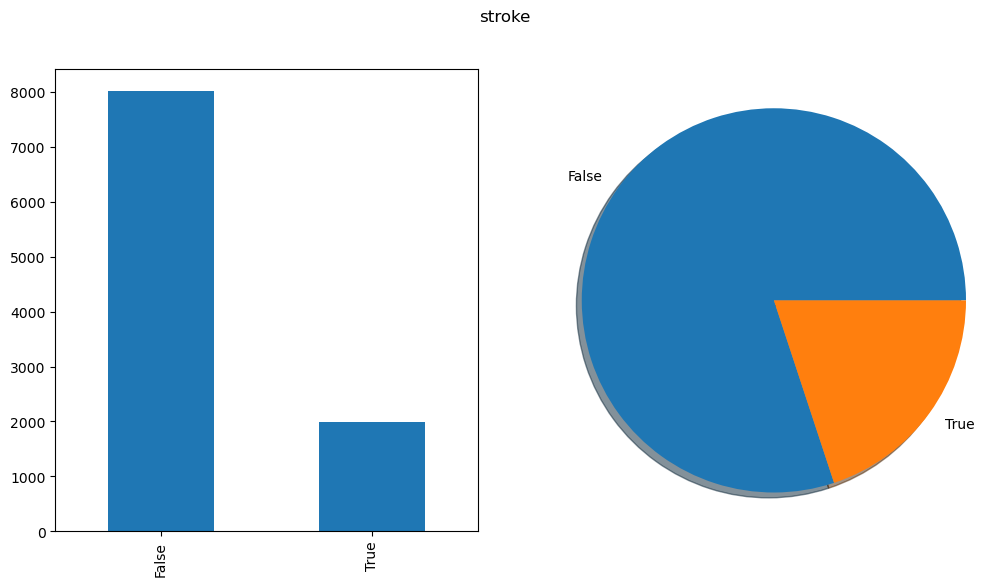

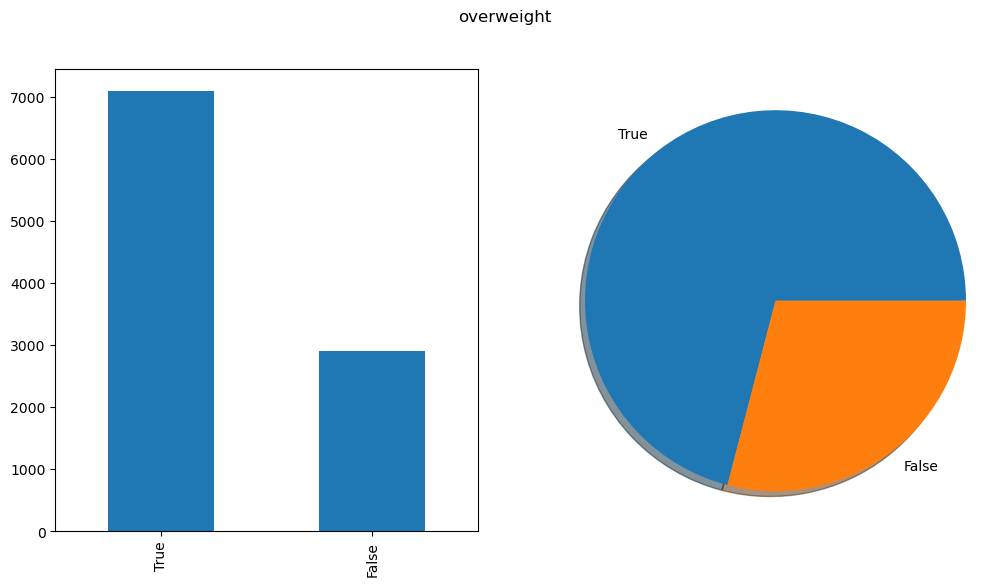

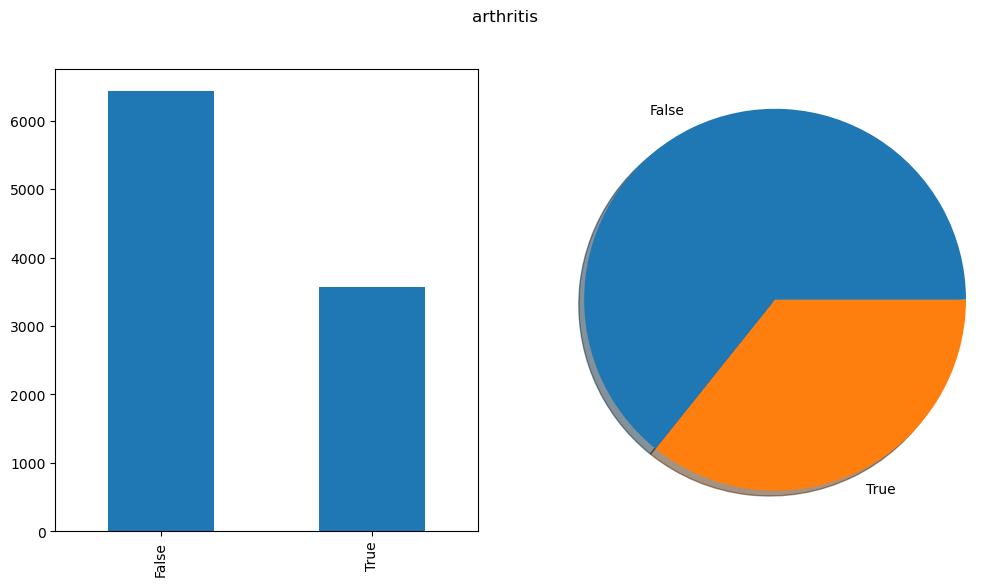

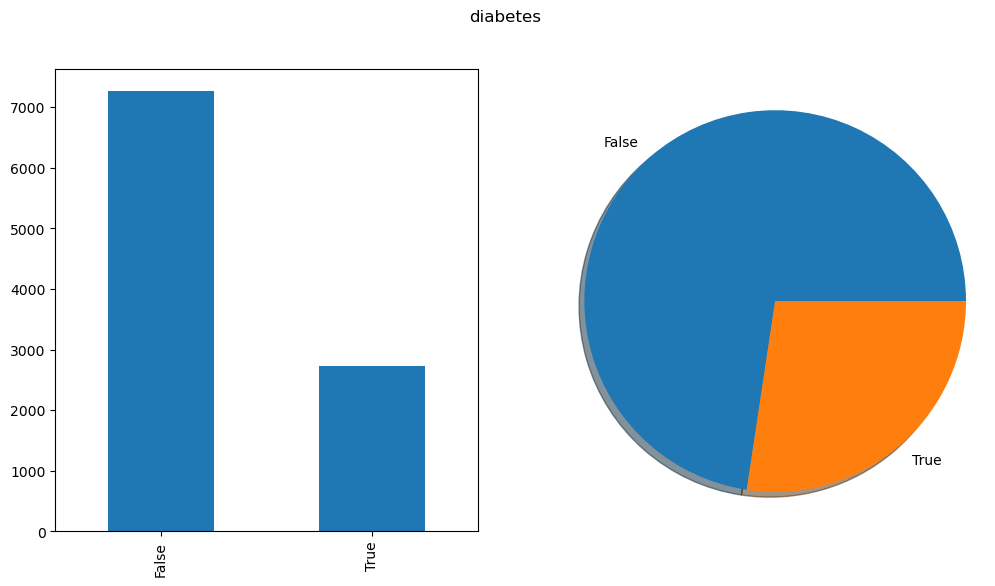

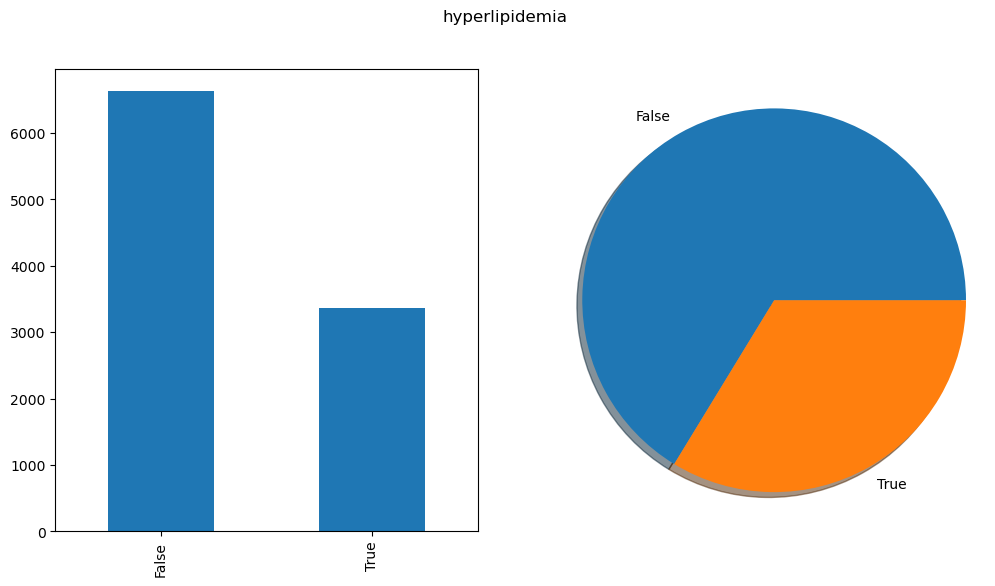

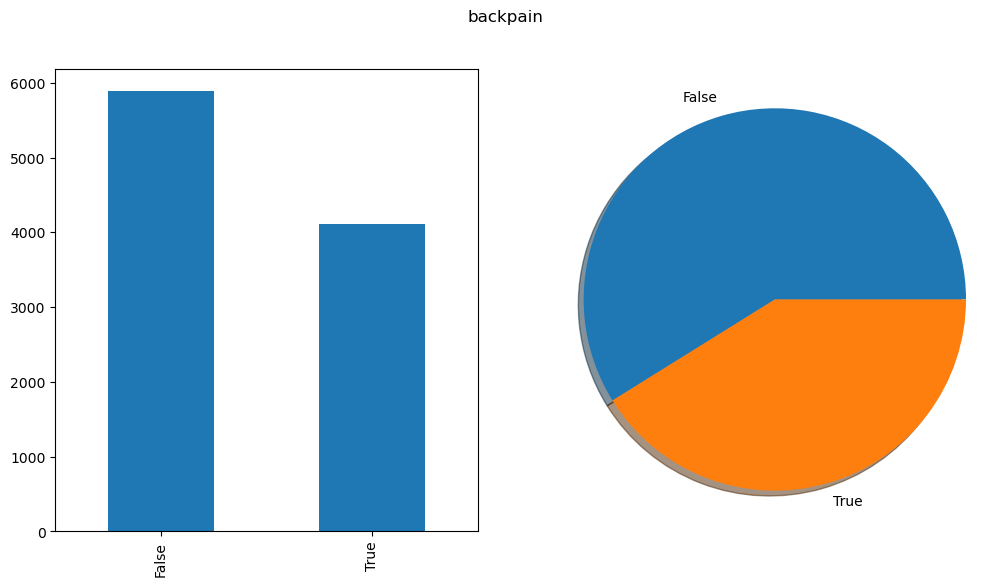

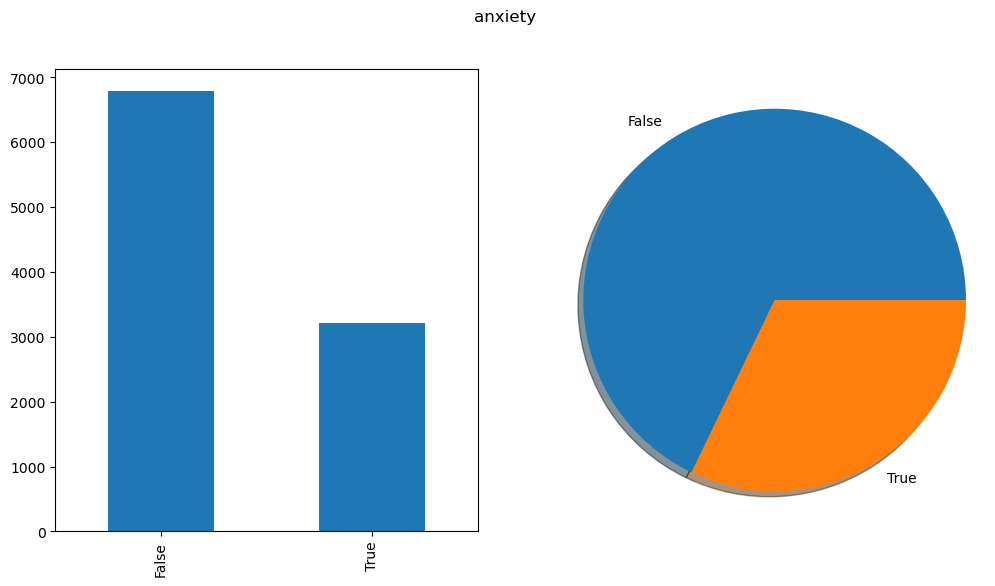

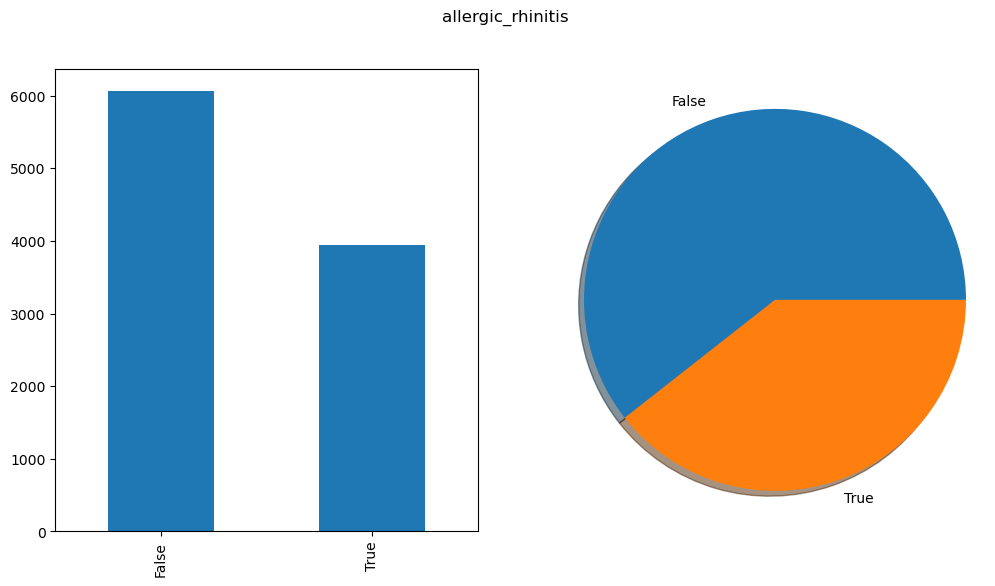

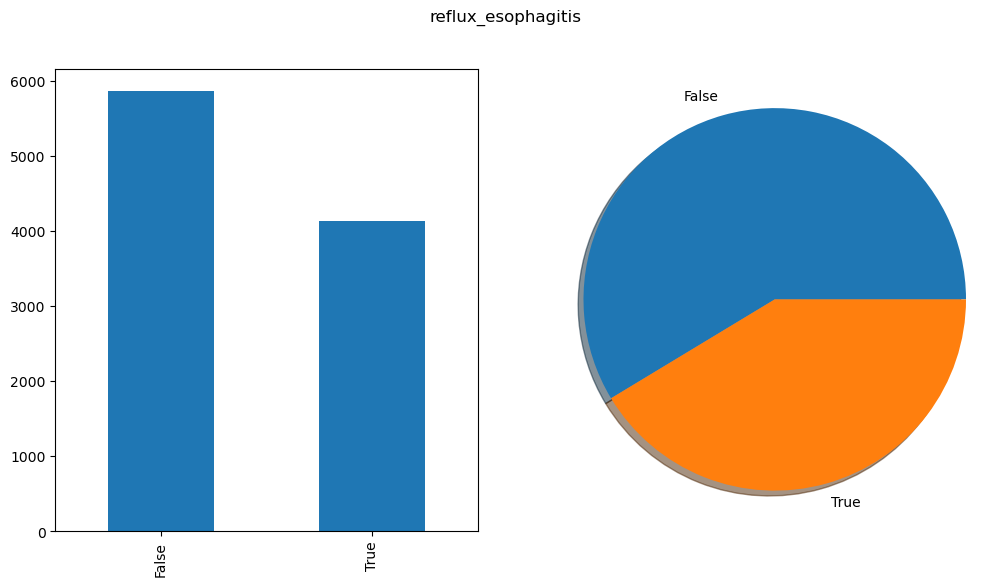

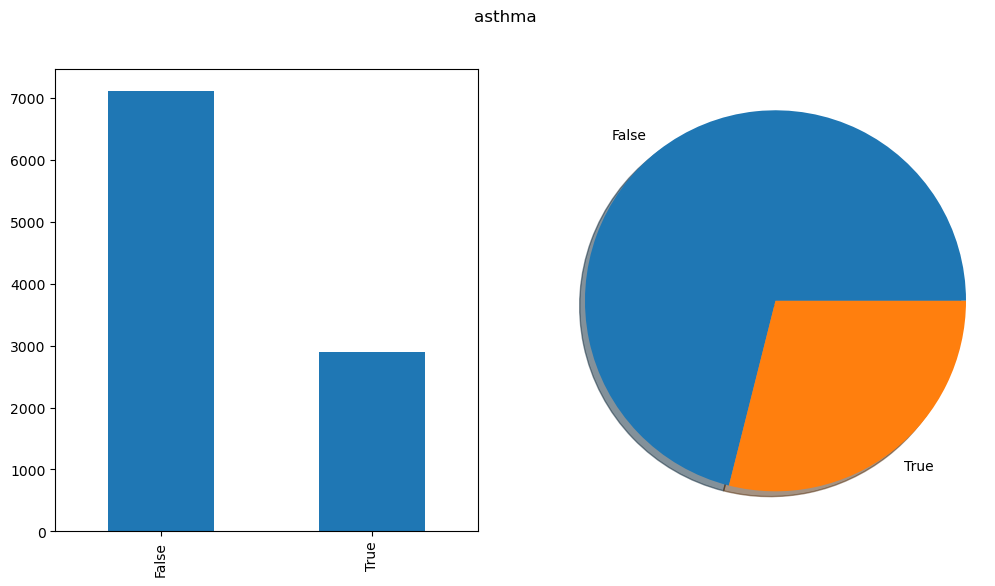

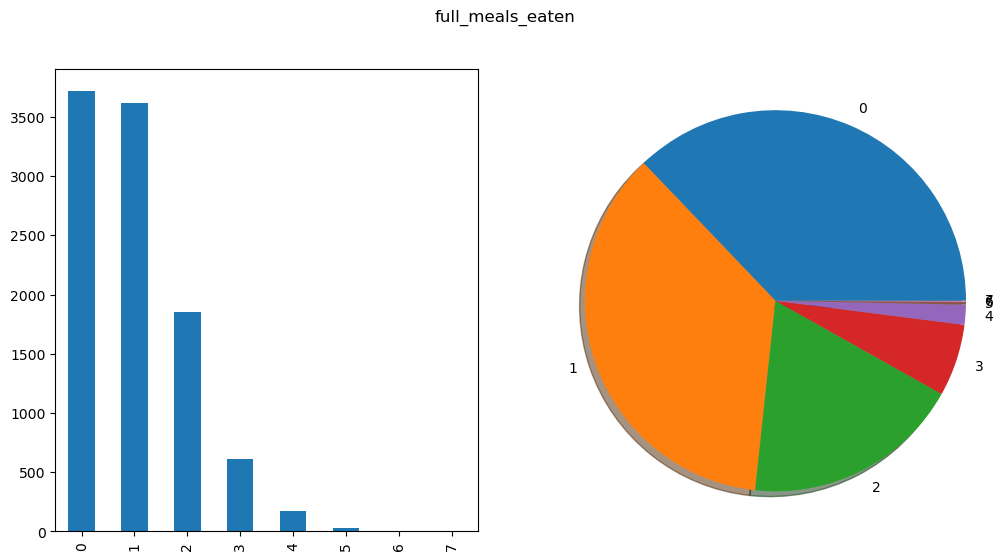

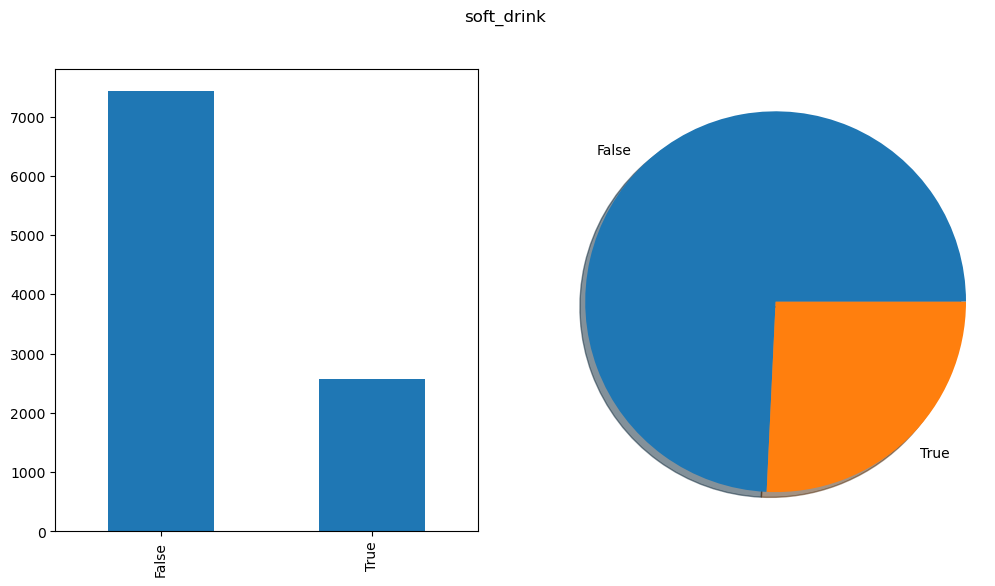

In [23]:
# Frequency distribution for boolean variables
print('Frequency distribution for boolean variables:')
for col in boolean_vars:
    plt.figure(figsize=(12,6))
#     print(f'\n{col}:')
    plt.subplot(1, 2, 1)
    df[col].value_counts().plot(kind='bar')
    
    plt.subplot(1, 2, 2)
    val_counts_dict = dict(df[col].value_counts())
    
    v = list(val_counts_dict.values())
    k = list(val_counts_dict.keys())
    plt.pie(v, labels = k, shadow=True)
    plt.axis('equal')
    plt.suptitle(col)
    plt.show()

#### Bivariate Visualizations

- Independent variables versus target variable.\
***Readmissions versus numerical variables***

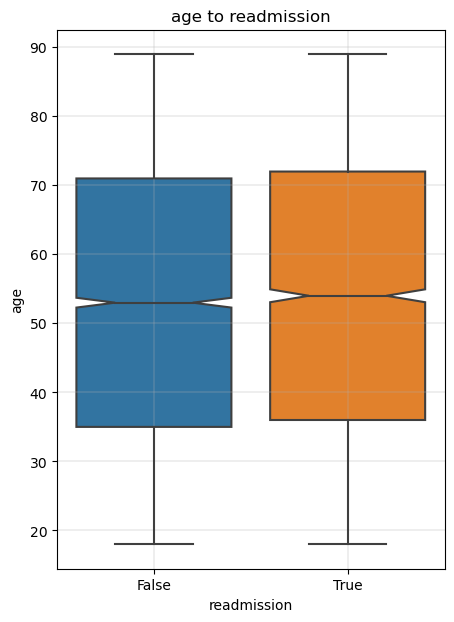

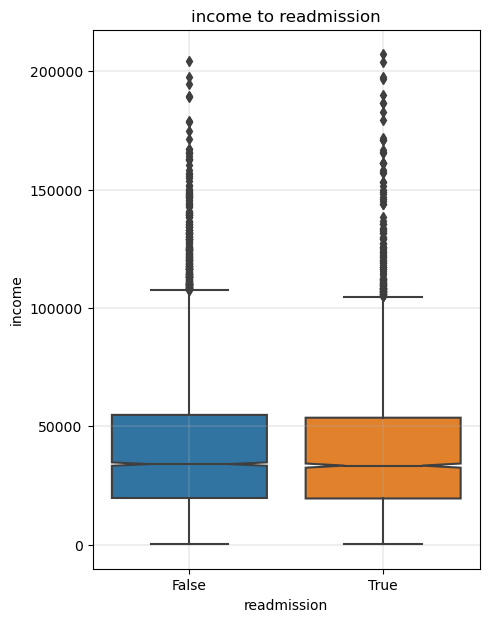

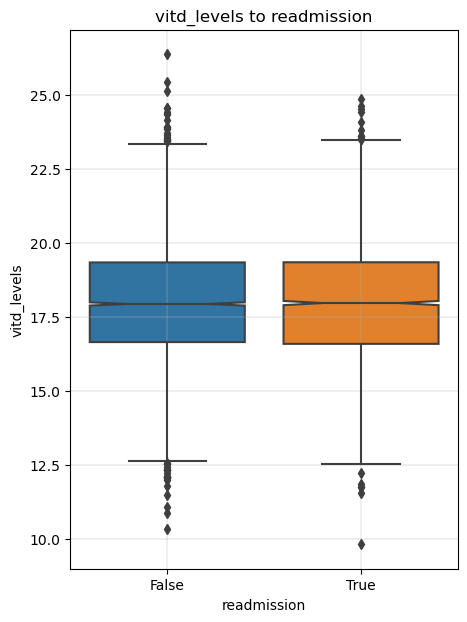

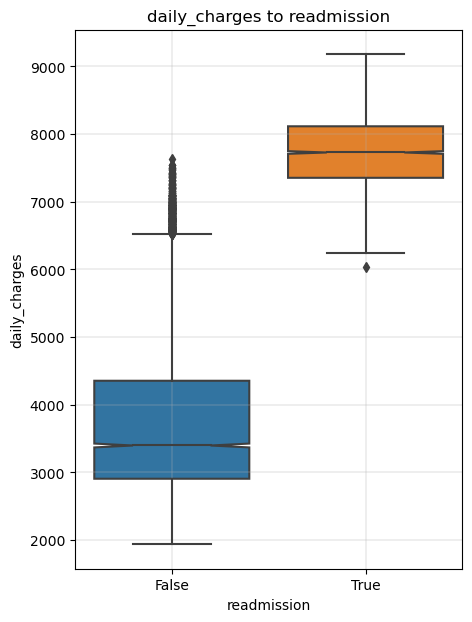

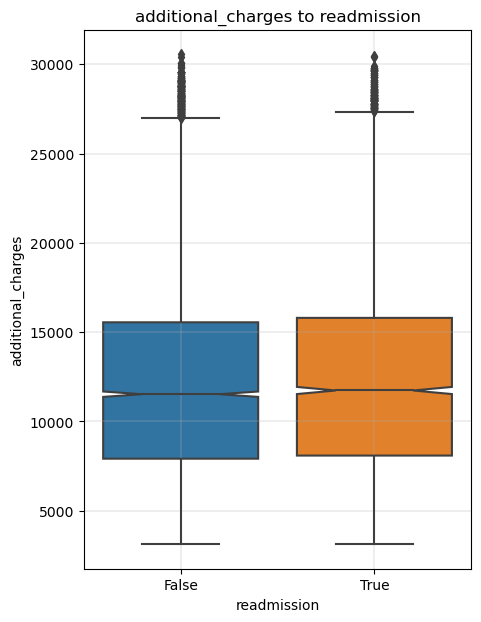

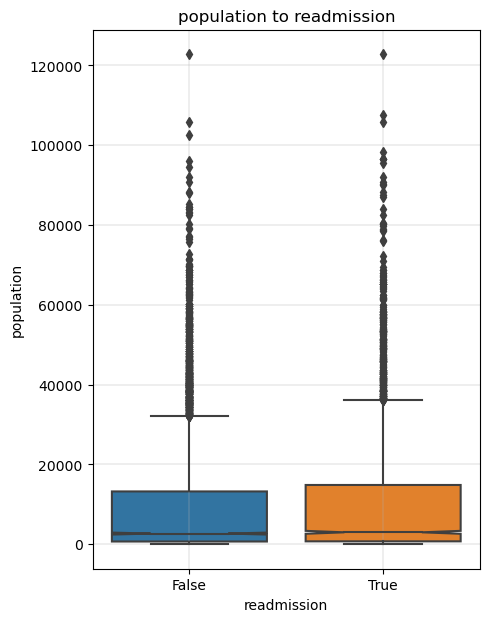

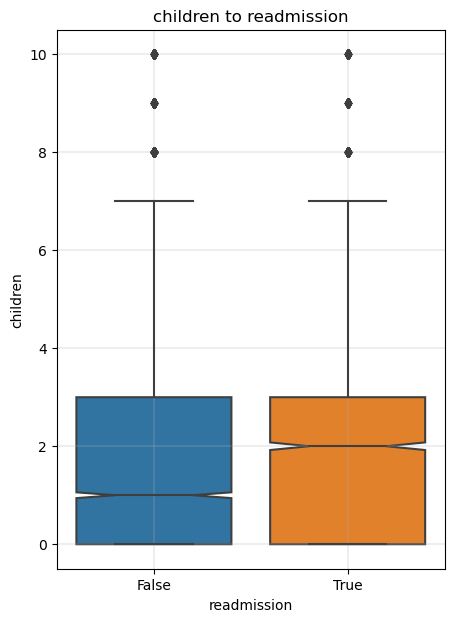

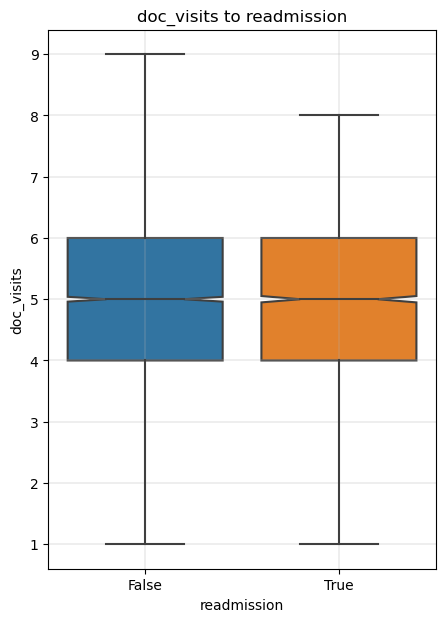

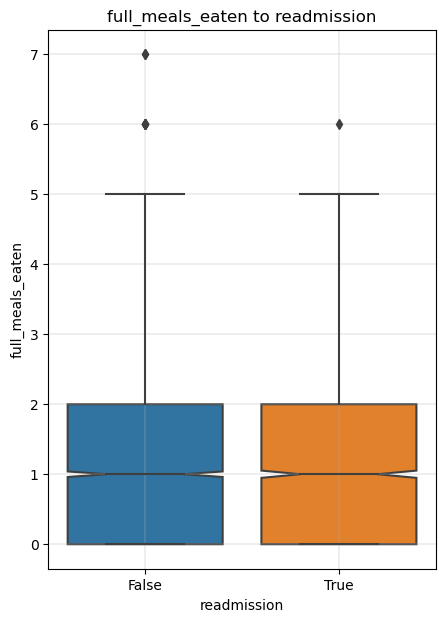

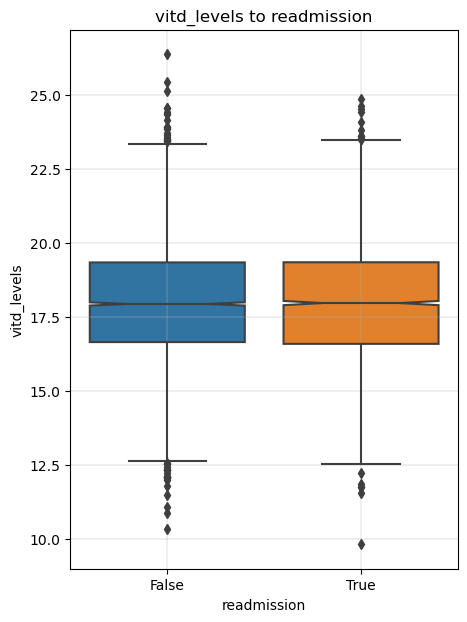

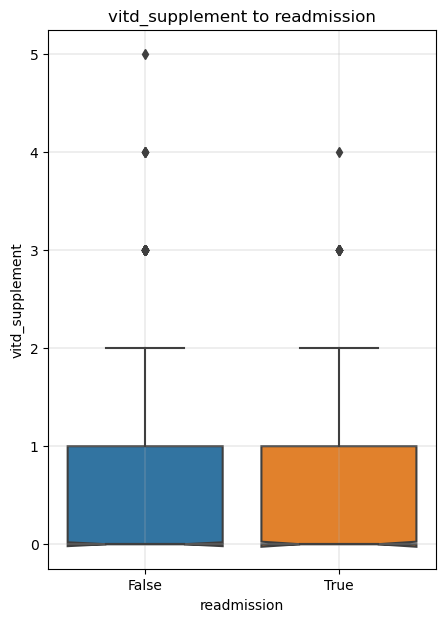

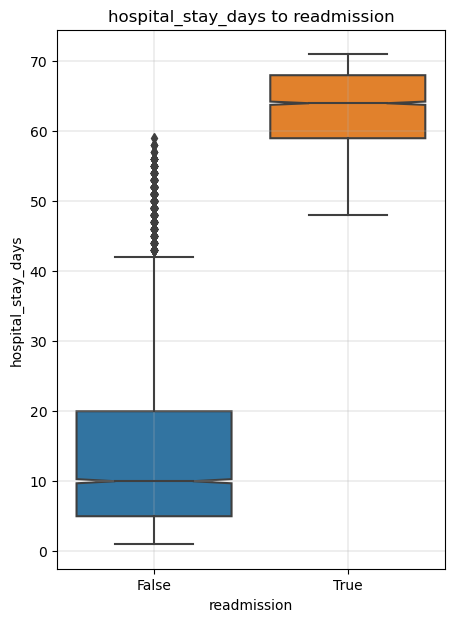

In [37]:
for i in ordinal_vars:
    plt.figure(figsize=(5,7))
    sns.boxplot(y=i, x='readmission', data=df, notch=True)
    plt.title(f'{i} to readmission')
    plt.grid(linewidth=0.3)
    plt.show()

***Quick Scope*** look for multicollinearity

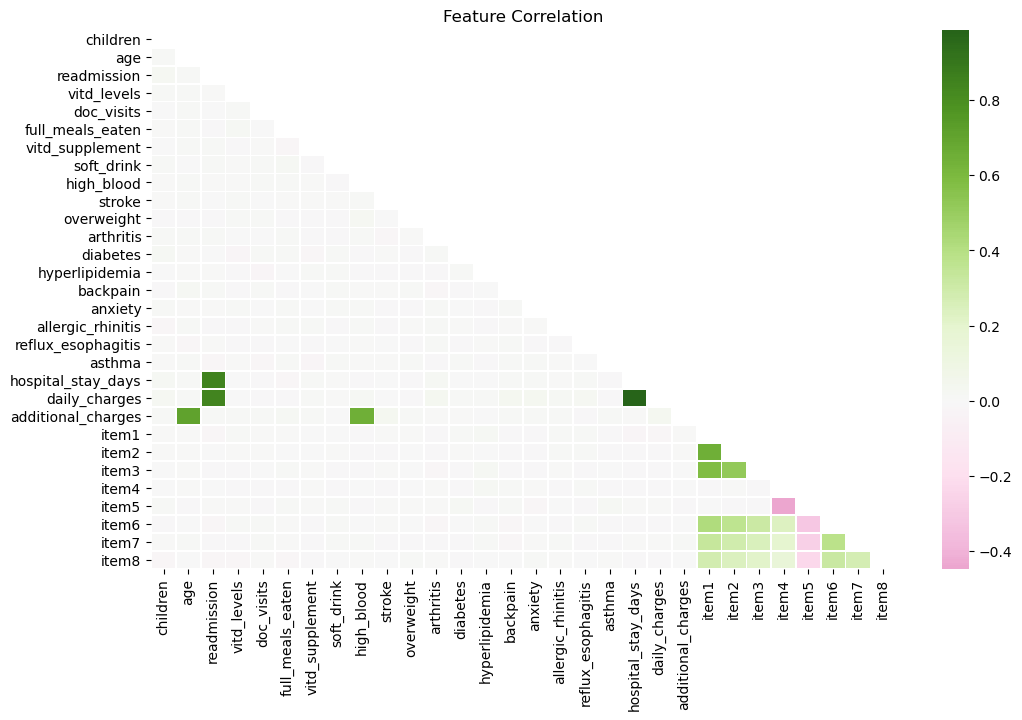

In [38]:
# take a look at a corner heatmap to assess correlation of independent variables
numerical = df.drop(columns=['CaseOrder',
                             'customer_id',
                             'interaction',
                             'unique_id',
                             'city',
                             'state',
                             'county',
                             'zip',
                             'lat',
                             'lng',
                             'population',
                             'income',
                             'job'])
corr = numerical.corr()


plt.figure(figsize=(12,7))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, center=0, linewidths=.5, cmap="PiYG", mask=mask)
plt.title('Feature Correlation')
plt.show()

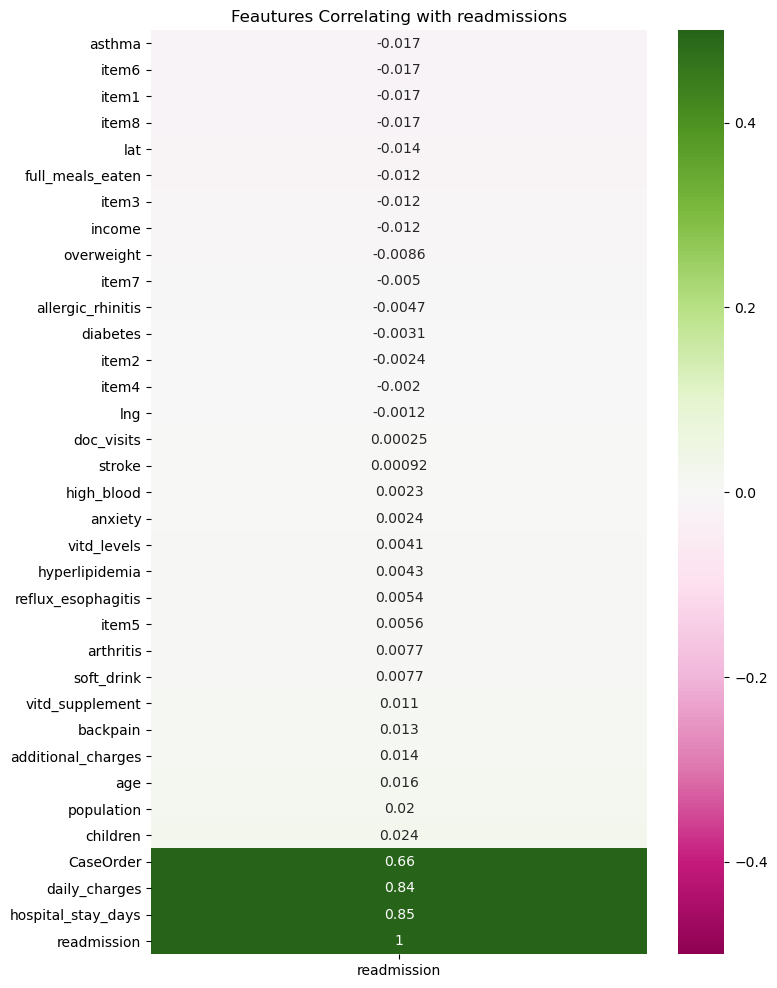

In [39]:
# Take a look at a heatmap of specific correlation to y target
plt.figure(figsize=(8,12))
value_heatmap = sns.heatmap(df.corr()[['readmission']].sort_values(by='readmission',
                                                                   ascending=True),
                            cmap="PiYG", vmin=-.5, vmax=.5, annot=True)
value_heatmap.set_title('Feautures Correlating with readmissions')
plt.show()

## C4.  Data transformation goals
- that align with your research question and the steps used to transform the data to achieve the goals, including the annotated code.


In order to prepare the data for modeling there a few required steps. Algorithms are not built to read text. So to start, all data must be transformed into readable numerical values.

Categorical variables will be engineered into binary dummy columns, representing each unique value within that feature. This process will ensure categorical data is correctly encoded for the model. Columns with Yes/No values will be transformed into 1/0, respectively to simplify their representation as boolean features.

Unique identifiers such as customer_id, interaction and unique_id are removed as they have no relevance to the prediction of stay. Other columns such as those related to location (e.g., city, state, zip) and variables like income and job, will also be omitted in this iteration for ethical considerations and practical analysis constraints. The job feature in particular, contains a large variety of values, making it less efficient to create dummy variables for each category. Instead, methods like clustering or binning could be explored in the future to group jobs meaningfully. Given that this is a minimum viable product (MVP) model, such advanced pre-processing steps can be deferred until necessary or later stages.

From the heatmap above, we observe a strong correlation between daily charges and hospital stay days with readmissions. It is important to consider whether these variables will be available during model deployment and live predictions. If we are predicting readmissions *after* a patient's release, and have access to both the length of stay and average daily charges at that point, then including these features makes sense for predictive modeling. However, if the goal is to predict readmissions *during* the patient's stay, these variables may not be available in real-time, and further clarification would be needed. For now, assuming we have this data post patient discharge, it seems reasonable to include them and proceed with the model.

Lastly, I also chose to remove the feature columns `item1` through `item8`. As expected, these columns have multicollinearity. If a patient answers 8 on one survey question, it is reasonable to assume they would choose the same or within the same range for consequent questions. Additionally, it would be more appropriate to bin them into more generalized categories so as to avoid redundant flag columns and avoid overfitting.

In [42]:
## remove unnecessary columns not used for modeling
remove_cols = ['CaseOrder',
               'customer_id',
               'interaction',
               'unique_id',
               'city',
               'state',
               'county',
               'zip',
               'lat',
               'lng',
               'income',
               'job',
               'timezone'
               # 'daily_charges',
               # 'additional_charges',
               # 'readmission'
                ,'item1'
                ,'item2'
                ,'item3'
                ,'item4'
                ,'item5'
                ,'item6'
                ,'item7'
                ,'item8']

filtered_df = df.drop(columns = remove_cols)

#### Nominal Categorical Features

The columns listed below are nominal categorical variables, meaning they represent categories without any inherent order or ranking. For use in a logistic regression model (and for any other), these categorical variables need to be transformed into numerical representations. However, assigning arbitrary numerical values to each category (e.g. 1 for female and 2 for male) would incorrectly imply a meaningful order and mislead the model. To address this, we use dummy variables, which convert each category into a binary (0 or 1) representation, ensuring that no ordinal relationship is inferred between the categories. This process enables the model to correctly interpret the categorical data without the issue of bias.

## C5.  Provide the prepared data set as a CSV file.

In [40]:
# df.to_csv('logistic_regression_cleaned_df.csv')

# Part IV: Model Comparison and Analysis

## D1.  Construct an initial logistic regression model from all independent variables that were identified in part C2.



2.  Justify a statistically based feature selection procedure or a model evaluation metric to reduce the initial model in a way that aligns with the research question.

3.  Provide a reduced logistic regression model that follows the feature selection or model evaluation process in part D2, including a screenshot of the output for each model.

E.  Analyze the data set using your reduced logistic regression model by doing the following:

1.  Explain your data analysis process by comparing the initial logistic regression model and reduced logistic regression model, including the following element:

•   a model evaluation metric

2.  Provide the output and all calculations of the analysis you performed, including the following elements for your reduced logistic regression model:

•   confusion matrix

•   accuracy calculation

3.  Provide an executable error-free copy of the code used to support the implementation of the logistic regression models using a Python or R file.



Part V: Data Summary and Implications

F.  Summarize your findings and assumptions by doing the following:

1.  Discuss the results of your data analysis, including the following elements:

•   a regression equation for the reduced model

•   an interpretation of the coefficients of the reduced model

•   the statistical and practical significance of the reduced model

•   the limitations of the data analysis

2.  Recommend a course of action based on your results.





Part VI: Demonstration

G.  Provide a Panopto video recording that includes the presenter and a vocalized demonstration of the functionality of the code used for the analysis of the programming environment, including the following elements:

•   an identification of the version of the programming environment

•   a comparison of the initial logistic regression model you used and the reduced logistic regression model you used in your analysis

•   an interpretation of the coefficients of the reduced model



Note: The audiovisual recording should feature you visibly presenting the material (i.e., not in voiceover or embedded video) and should simultaneously capture both you and your multimedia presentation.


Note: For instructions on how to access and use Panopto, use the "Panopto How-To Videos" web link provided below. To access Panopto's website, navigate to the web link titled "Panopto Access," and then choose to log in using the “WGU” option. If prompted, log in using your WGU student portal credentials, and then it will forward you to Panopto’s website.


To submit your recording, upload it to the Panopto drop box titled “Regression Modeling – NBM3 | D208.” Once the recording has been uploaded and processed in Panopto's system, retrieve the URL of the recording from Panopto and copy and paste it into the Links option. Upload the remaining task requirements using the Attachments option.



H.  List the web sources used to acquire data or segments of third-party code to support the application. Ensure the web sources are reliable.


I.  Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.


J.  Demonstrate professional communication in the content and presentation of your submission.

# H. Sources
https://www.spiceworks.com/tech/artificial-intelligence/articles/what-is-logistic-regression/


  https://www.geeksforgeeks.org/understanding-logistic-regression/

In [ ]:
# Take a look at a heatmap of correlation to y target
plt.figure(figsize=(8,12))
value_heatmap = sns.heatmap(df.corr()[['readmission']].sort_values(by='readmission', ascending=True),
                            cmap="PiYG", vmin=-.5, vmax=.5, annot=True)
value_heatmap.set_title('Feautures Correlating with hospital_stay_days')
plt.show()